In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.signal import welch, spectrogram
import math
import librosa
import scipy.signal
import os
import warnings
import random
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.signal
from torch.utils.data import Dataset, DataLoader, random_split
from collections import defaultdict
import torchaudio.transforms as T
import torch.nn.functional as F
from scipy.signal import resample
from tqdm import tqdm
from geomloss import SamplesLoss
import os
import time
from tqdm import tqdm
import csv
import geomloss
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def set_all_seeds(num):
    random.seed(num)
    np.random.seed(num)
    torch.manual_seed(num)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(num)

set_all_seeds(42)

## Configuración inicial para generar dataset sinteticos

In [3]:
base_path = "./features/time_domain_win_cut_pad/"
categories = ["chew", "elpp", "shiv"]
file_limit = 4266  
grouped_files = defaultdict(list)

if not os.path.exists(base_path):
    print(f"Error: Directory '{base_path}' not found.")
    exit()

print(f"Scanning directory: {base_path}\n")

for root, dirs, files in os.walk(base_path):
    folder_name = os.path.basename(root)
    
    if folder_name in categories:
        print(f"Processing folder: {folder_name}, Found {len(files)} files.")

        for file in files:
            if file.endswith(".pt") and len(grouped_files[folder_name]) < file_limit:
                file_path = os.path.join(root, file)
                grouped_files[folder_name].append(file_path)
                print(f"Added {file} to category '{folder_name}'")

Scanning directory: ./features/time_domain_win_cut_pad/

Processing folder: chew, Found 4266 files.
Added C3-CZ_0.0_21.0048.pt to category 'chew'
Added C3-CZ_0.2405_2.5624.pt to category 'chew'
Added C3-CZ_10.4038_12.6573.pt to category 'chew'
Added C3-CZ_100.0431_110.1627.pt to category 'chew'
Added C3-CZ_1002.0443_1005.8908.pt to category 'chew'
Added C3-CZ_1007.3117_1010.1994.pt to category 'chew'
Added C3-CZ_1026.2655_1029.0685.pt to category 'chew'
Added C3-CZ_105.0722_110.9278.pt to category 'chew'
Added C3-CZ_105.7222_115.6.pt to category 'chew'
Added C3-CZ_1067.0648_1079.0259.pt to category 'chew'
Added C3-CZ_1086.1008_1120.6059.pt to category 'chew'
Added C3-CZ_1130.2026_1142.4228.pt to category 'chew'
Added C3-CZ_114.0141_129.7887.pt to category 'chew'
Added C3-CZ_114.0481_119.7789.pt to category 'chew'
Added C3-CZ_115.0957_119.5215.pt to category 'chew'
Added C3-CZ_115.2294_179.9893.pt to category 'chew'
Added C3-CZ_1152.0601_1154.6503.pt to category 'chew'
Added C3-CZ_116.1

In [4]:
chew_data = np.stack([torch.load(x, weights_only=False) for x in grouped_files['chew']], axis=0)
elpp_data = np.stack([torch.load(x, weights_only=False) for x in grouped_files['elpp']], axis=0)
shiv_data = np.stack([torch.load(x, weights_only=False) for x in grouped_files['shiv']], axis=0)

In [5]:
print(chew_data.shape)
print(elpp_data.shape)
print(shiv_data.shape)

(4266, 512)
(156, 512)
(2762, 512)


In [6]:
EEG_PATH = 'data'
EOG_ALL_EPOCHS = 'EOG_all_epochs.npy'
EMG_ALL_EPOCHS = 'EMG_all_epochs.npy'
EEG_ALL_EPOCHS = 'EEG_all_epochs.npy'

In [7]:
def show_data_informations(signal, signal_type):
    print(f"Data type {signal_type}:", type(signal))
    print(f"Data shape {signal_type}:", signal.shape)

In [8]:
eog_data = np.load(os.path.join(EEG_PATH, EOG_ALL_EPOCHS))
emg_data = np.load(os.path.join(EEG_PATH, EMG_ALL_EPOCHS))
eeg_data = np.load(os.path.join(EEG_PATH, EEG_ALL_EPOCHS))

show_data_informations(eog_data, 'EOG')
show_data_informations(emg_data, 'EMG')
show_data_informations(eeg_data, 'EEG')

Data type EOG: <class 'numpy.ndarray'>
Data shape EOG: (3400, 512)
Data type EMG: <class 'numpy.ndarray'>
Data shape EMG: (5598, 512)
Data type EEG: <class 'numpy.ndarray'>
Data shape EEG: (4514, 512)


In [9]:
def get_rms(records):
    return math.sqrt(sum([x ** 2 for x in records]) / len(records))

def random_signal(signal, combine_num):
    random_result=[]
    for i in range(combine_num):
        random_num = np.random.permutation(signal.shape[0])
        shuffled_dataset = signal[random_num, :]
        shuffled_dataset = shuffled_dataset.reshape(signal.shape[0],signal.shape[1])
        random_result.append(shuffled_dataset)
    random_result  = np.array(random_result)
    return  random_result

In [10]:
EEG_all_random = np.squeeze(random_signal(signal=eeg_data, combine_num=1))

NOISE_all_random_chew = np.squeeze(random_signal(signal=chew_data, combine_num=1))
NOISE_all_random_elpp = np.squeeze(random_signal(signal=elpp_data, combine_num=1))
NOISE_all_random_shiv = np.squeeze(random_signal(signal=shiv_data, combine_num=1))
NOISE_all_random_eog = np.squeeze(random_signal(signal=eog_data, combine_num=1))
NOISE_all_random_emg = np.squeeze(random_signal(signal=emg_data, combine_num=1))

In [11]:
SNR_dB_chew = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_elpp = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_shiv = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_eog = np.random.uniform(-7, 2, (eeg_data.shape[0]))
SNR_dB_emg = np.random.uniform(-7, 2, (eeg_data.shape[0]))

In [12]:
SNR_chew = 10 ** (0.1 * SNR_dB_chew)
SNR_elpp = 10 ** (0.1 * SNR_dB_elpp)
SNR_shiv = 10 ** (0.1 * SNR_dB_shiv)
SNR_eog = 10 ** (0.1 * SNR_dB_eog)
SNR_emg = 10 ** (0.1 * SNR_dB_emg)

In [13]:
num_eeg_samples = EEG_all_random.shape[0]
num_chew_samples = chew_data.shape[0]
num_elpp_samples = elpp_data.shape[0]
num_shiv_samples = shiv_data.shape[0]
num_eog_samples = eog_data.shape[0]
num_emg_samples = emg_data.shape[0]

In [14]:
needed_repetitions_chew = int(np.ceil(num_eeg_samples / num_chew_samples))
needed_repetitions_elpp = int(np.ceil(num_eeg_samples / num_elpp_samples))
needed_repetitions_shiv = int(np.ceil(num_eeg_samples / num_shiv_samples))
needed_repetitions_eog = int(np.ceil(num_eeg_samples / num_eog_samples))
needed_repetitions_emg = int(np.ceil(num_eeg_samples / num_emg_samples))

In [15]:
NOISE_all_random_chew = random_signal(signal=chew_data, combine_num=needed_repetitions_chew)
NOISE_all_random_elpp = random_signal(signal=elpp_data, combine_num=needed_repetitions_elpp)
NOISE_all_random_shiv = random_signal(signal=shiv_data, combine_num=needed_repetitions_shiv)
NOISE_all_random_eog = random_signal(signal=eog_data, combine_num=needed_repetitions_eog)
NOISE_all_random_emg = random_signal(signal=emg_data, combine_num=needed_repetitions_emg)

NOISE_all_random_chew = NOISE_all_random_chew.reshape(-1, chew_data.shape[1])
NOISE_all_random_elpp = NOISE_all_random_elpp.reshape(-1, elpp_data.shape[1])
NOISE_all_random_shiv = NOISE_all_random_shiv.reshape(-1, shiv_data.shape[1])
NOISE_all_random_eog = NOISE_all_random_eog.reshape(-1, eog_data.shape[1])
NOISE_all_random_emg = NOISE_all_random_emg.reshape(-1, emg_data.shape[1])

In [16]:
if NOISE_all_random_chew.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_chew.shape[0]
    extra_noise = random_signal(signal=chew_data, combine_num=1).reshape(-1, chew_data.shape[1])
    NOISE_all_random_chew = np.concatenate((NOISE_all_random_chew, extra_noise), axis=0)

if NOISE_all_random_elpp.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_elpp.shape[0]
    extra_noise = random_signal(signal=elpp_data, combine_num=1).reshape(-1, elpp_data.shape[1])
    NOISE_all_random_elpp = np.concatenate((NOISE_all_random_elpp, extra_noise), axis=0)
    
if NOISE_all_random_shiv.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_shiv.shape[0]
    extra_noise = random_signal(signal=shiv_data, combine_num=1).reshape(-1, shiv_data.shape[1])
    NOISE_all_random_shiv = np.concatenate((NOISE_all_random_shiv, extra_noise), axis=0)

if NOISE_all_random_eog.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_eog.shape[0]
    extra_noise = random_signal(signal=eog_data, combine_num=1).reshape(-1, eog_data.shape[1])
    NOISE_all_random_eog = np.concatenate((NOISE_all_random_eog, extra_noise), axis=0)

if NOISE_all_random_emg.shape[0] < num_eeg_samples:
    extra_needed = num_eeg_samples - NOISE_all_random_emg.shape[0]
    extra_noise = random_signal(signal=emg_data, combine_num=1).reshape(-1, emg_data.shape[1])
    NOISE_all_random_emg = np.concatenate((NOISE_all_random_emg, extra_noise), axis=0)

In [17]:
NOISE_all_random_chew = NOISE_all_random_chew[:num_eeg_samples]
NOISE_all_random_elpp = NOISE_all_random_elpp[:num_eeg_samples]
NOISE_all_random_shiv = NOISE_all_random_shiv[:num_eeg_samples]
NOISE_all_random_eog = NOISE_all_random_eog[:num_eeg_samples]
NOISE_all_random_emg = NOISE_all_random_emg[:num_eeg_samples]

In [18]:
noiseEEG_CHEW = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_chew = NOISE_all_random_chew[i]
    coe_chew = get_rms(eeg) / (get_rms(noise_chew) * SNR_chew[i])
    noise_chew = noise_chew * coe_chew
    noise_eeg_chew = eeg + noise_chew
    noiseEEG_CHEW.append(noise_eeg_chew)

noiseEEG_ELPP = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_elpp = NOISE_all_random_elpp[i]
    coe_elpp = get_rms(eeg) / (get_rms(noise_elpp) * SNR_elpp[i])
    noise_elpp = noise_elpp * coe_elpp
    noise_eeg_elpp = eeg + noise_elpp
    noiseEEG_ELPP.append(noise_eeg_elpp)

noiseEEG_SHIV = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_shiv = NOISE_all_random_shiv[i]
    coe_shiv = get_rms(eeg) / (get_rms(noise_shiv) * SNR_shiv[i])
    noise_shiv = noise_shiv * coe_shiv
    noise_eeg_shiv = eeg + noise_shiv
    noiseEEG_SHIV.append(noise_eeg_shiv)

noiseEEG_EOG = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_eog = NOISE_all_random_eog[i]
    coe_eog = get_rms(eeg) / (get_rms(noise_eog) * SNR_eog[i])
    noise_eog = noise_eog * coe_eog
    noise_eeg_eog = eeg + noise_eog
    noiseEEG_EOG.append(noise_eeg_eog)

noiseEEG_EMG = []
for i in range(num_eeg_samples):
    eeg = EEG_all_random[i]
    noise_emg = NOISE_all_random_emg[i]
    coe_emg = get_rms(eeg) / (get_rms(noise_emg) * SNR_emg[i])
    noise_emg = noise_emg * coe_emg
    noise_eeg_emg = eeg + noise_emg
    noiseEEG_EMG.append(noise_eeg_emg)

In [19]:
noiseEEG_CHEW = np.array(noiseEEG_CHEW)
noiseEEG_ELPP = np.array(noiseEEG_ELPP)
noiseEEG_SHIV = np.array(noiseEEG_SHIV)
noiseEEG_EOG = np.array(noiseEEG_EOG)
noiseEEG_EMG = np.array(noiseEEG_EMG)

In [20]:
EEG_end_standard = EEG_all_random / np.std(EEG_all_random)
noiseEEG_CHEW_standard = noiseEEG_CHEW / np.std(noiseEEG_CHEW)
noiseEEG_ELPP_standard = noiseEEG_ELPP / np.std(noiseEEG_ELPP)
noiseEEG_SHIV_standard = noiseEEG_SHIV / np.std(noiseEEG_SHIV)
noiseEEG_EOG_standard = noiseEEG_EOG / np.std(noiseEEG_EOG)
noiseEEG_EMG_standard = noiseEEG_EMG / np.std(noiseEEG_EMG)

In [21]:
EEG = EEG_end_standard.flatten()
EEG_CHEW = noiseEEG_CHEW_standard.flatten()
EEG_ELPP = noiseEEG_ELPP_standard.flatten()
EEG_SHIV = noiseEEG_SHIV_standard.flatten()
EEG_EOG = noiseEEG_EOG_standard.flatten()
EEG_EMG = noiseEEG_EMG_standard.flatten()

In [22]:
print(f'EEG: {EEG.shape}')
print(f'EEG_CHEW: {EEG_CHEW.shape}')
print(f'EEG_ELPP: {EEG_ELPP.shape}')
print(f'EEG_SHIV: {EEG_SHIV.shape}')
print(f'EEG_EOG: {EEG_EOG.shape}')
print(f'EEG_EMG: {EEG_EMG.shape}')

EEG: (2311168,)
EEG_CHEW: (2311168,)
EEG_ELPP: (2311168,)
EEG_SHIV: (2311168,)
EEG_EOG: (2311168,)
EEG_EMG: (2311168,)


## Generar dataset real

In [23]:
features_path = './features/time_domain_win_cut_pad/'
files_by_subfolder = {}

for root, dirs, files in os.walk(features_path):
    relative_path = os.path.relpath(root, features_path)
    if relative_path == '.':
        continue
    if relative_path not in files_by_subfolder:
        files_by_subfolder[relative_path] = []
    for file in files:
        full_path = os.path.join(root, file)
        files_by_subfolder[relative_path].append(full_path)

value_map = {'base':0, 'chew':1,  'elpp':2, 'eyem': 3, 'musc': 4, 'shiv':5}
selected_pt_files = []
selected_labels = []

for subfolder, files in files_by_subfolder.items():
    if subfolder in value_map:
        class_label = value_map[subfolder]
    
        sampled_files = random.sample(files, min(len(files), 4514))
        
        selected_pt_files.extend(sampled_files)
        selected_labels.extend([class_label] * len(sampled_files))

for class_name, class_id in value_map.items():
    count = sum(1 for lbl in selected_labels if lbl == class_id)
    print(f"Class {class_name} (ID {class_id}): {count} samples")

Class base (ID 0): 4514 samples
Class chew (ID 1): 4266 samples
Class elpp (ID 2): 156 samples
Class eyem (ID 3): 4514 samples
Class musc (ID 4): 4514 samples
Class shiv (ID 5): 2762 samples


In [24]:
class CustomDatasetTarget(Dataset):
    def __init__(self, files, labelss, normalization_type='min_max'):
        self.files = files
        self.labels = labelss
        self.normalization_type = normalization_type

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        data = torch.load(file_path, weights_only=False)

        if isinstance(data, np.ndarray):
            data = data.astype(np.float32)
        elif isinstance(data, torch.Tensor):
            data = data.to(torch.float32).unsqueeze(-1)
        else:
            raise ValueError(f"Unsupported data type for file: {file_path}")

        if self.normalization_type == 'min_max':
            data = self.min_max_normalize(data)
        elif self.normalization_type == 'standardize':
            data = self.standardize(data)
        else:
            raise ValueError(f"Unsupported normalization type: {self.normalization_type}")

        return data, label

    def min_max_normalize(self, data):
        min_val = data.min()
        max_val = data.max()
        return (data - min_val) / (max_val - min_val)

    def standardize(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std

In [25]:
dataset_source = CustomDatasetTarget(selected_pt_files, selected_labels, normalization_type='standardize')

In [26]:
class CustomEEGDataset(Dataset):
    def __init__(self, eeg, eeg_chew,  eeg_elpp, eeg_eog, eeg_emg, eeg_shiv, window_size=512):
        self.signals = self.signals = [
            (self.normalize(eeg), 0),
            (self.normalize(eeg_chew), 1),
            (self.normalize(eeg_elpp), 2),
            (self.normalize(eeg_eog), 3),
            (self.normalize(eeg_emg), 4),
            (self.normalize(eeg_shiv), 5)
        ]
        self.window_size = window_size
        self.samples = []
        
        for signal, label in self.signals:
            num_samples = len(signal) // window_size
            for i in range(num_samples):
                start = i * window_size
                end = start + window_size
                self.samples.append((torch.tensor(signal[start:end], dtype=torch.float32), label))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample, label = self.samples[idx]
        return sample, torch.tensor(label, dtype=torch.long)
    
    @staticmethod
    def normalize(data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std

def get_dataloaders(eeg, eeg_chew, eeg_elpp, eeg_eog, eeg_emg, eeg_shiv, batch_size=32, shuffle=True):
    dataset = CustomEEGDataset(eeg, eeg_chew, eeg_elpp, eeg_eog, eeg_emg, eeg_shiv)
    
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5:0}
    for _, label in dataset.samples:
        class_counts[label] += 1
    
    print("\n=== Sample Counts Per Class ===")
    print(f"EEG (0)  : {class_counts[0]}")
    print(f"Chew (1)  : {class_counts[1]}")
    print(f"Elpp (2)  : {class_counts[2]}")
    print(f"EOG  (3)  : {class_counts[3]}")
    print(f"EMG  (4)  : {class_counts[4]}")
    print(f"Shiv (5)  : {class_counts[5]}\n")
    return dataset

In [27]:
dataset_target = get_dataloaders(
    EEG, 
    EEG_CHEW[0:4266*512+1],
    EEG_ELPP[0:156*512+1], 
    EEG_EOG, 
    EEG_EMG, 
    EEG_SHIV[0:2347*512+1], 
    batch_size=32, shuffle=False)


=== Sample Counts Per Class ===
EEG (0)  : 4514
Chew (1)  : 4266
Elpp (2)  : 156
EOG  (3)  : 4514
EMG  (4)  : 4514
Shiv (5)  : 2347



## Alinear para entrenamiento source y taget

In [28]:
class AlignedEEGDataset(Dataset):
    def __init__(self, dataset_source, dataset_target):
        self.dataset_source = dataset_source
        self.dataset_target = dataset_target
        self.min_length = min(len(dataset_source), len(dataset_target))
    
    def __len__(self):
        return self.min_length
    
    def __getitem__(self, idx):
        x_feat_source, y_label_source = self.dataset_source[idx]
        x_feat_target, y_label_target = self.dataset_target[idx]
        
        return x_feat_source, y_label_source, x_feat_target, y_label_target

In [29]:
import random
import torch
from torch.utils.data import DataLoader, random_split, Dataset

class AlignedEEGDataset(Dataset):
    def __init__(self, dataset_source, dataset_target, n_fft=128, hop_length=64, norm_type="zscore", 
                 apply_specaug_source=False, time_masking_ratio=0.1, freq_masking_ratio=0.1):
        self.dataset_source = dataset_source
        self.dataset_target = dataset_target
        self.min_length = min(len(dataset_source), len(dataset_target))
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.norm_type = norm_type
        self.apply_specaug_source = apply_specaug_source
        self.time_masking_ratio = time_masking_ratio
        self.freq_masking_ratio = freq_masking_ratio

    def __len__(self):
        return self.min_length
    
    def apply_stft(self, eeg_signal):
        return torch.stft(eeg_signal, n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True).abs()

    def normalize_minmax(self, tensor):
        min_val = tensor.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
        max_val = tensor.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
        return (tensor - min_val) / (max_val - min_val + 1e-8)

    def normalize_zscore(self, tensor):
        mean = tensor.mean(dim=(-1, -2), keepdim=True)
        std = tensor.std(dim=(-1, -2), keepdim=True) + 1e-8
        return (tensor - mean) / std

    def normalize(self, tensor):
        if self.norm_type == "minmax":
            return self.normalize_minmax(tensor)
        elif self.norm_type == "zscore":
            return self.normalize_zscore(tensor)
        else:
            return tensor

    def spec_augment(self, spectrogram):
        # Apply Frequency Masking
        num_freq_bins = spectrogram.shape[-2]
        num_time_bins = spectrogram.shape[-1]

        # Frequency Masking
        num_freq_mask = int(self.freq_masking_ratio * num_freq_bins)
        if num_freq_mask > 0:
            f_start = random.randint(0, num_freq_bins - num_freq_mask)
            spectrogram[f_start:f_start + num_freq_mask, :] = 0.0

        # Time Masking
        num_time_mask = int(self.time_masking_ratio * num_time_bins)
        if num_time_mask > 0:
            t_start = random.randint(0, num_time_bins - num_time_mask)
            spectrogram[:, t_start:t_start + num_time_mask] = 0.0

        return spectrogram

    def __getitem__(self, idx):
        x_feat_source, y_label_source = self.dataset_source[idx]
        x_feat_target, y_label_target = self.dataset_target[idx]

        x_feat_source = torch.tensor(x_feat_source, dtype=torch.float32)
        x_feat_target = torch.tensor(x_feat_target, dtype=torch.float32)

        x_feat_source_stft = self.apply_stft(x_feat_source)
        x_feat_target_stft = self.apply_stft(x_feat_target)

        x_feat_source_stft = self.normalize(x_feat_source_stft)
        x_feat_target_stft = self.normalize(x_feat_target_stft)

        if self.apply_specaug_source:
            x_feat_source_stft = self.spec_augment(x_feat_source_stft)

        return x_feat_source_stft.unsqueeze(0), y_label_source, x_feat_target_stft.unsqueeze(0), y_label_target


def get_aligned_dataloaders(dataset_source, dataset_target, batch_size=32, shuffle=True, norm_type="zscore",
                            apply_specaug_source=False):
    aligned_dataset = AlignedEEGDataset(
        dataset_source, dataset_target, norm_type=norm_type,
        apply_specaug_source=apply_specaug_source
    )
    
    train_size = int(0.8 * len(aligned_dataset))
    test_size = len(aligned_dataset) - train_size
    train_dataset, test_dataset = random_split(aligned_dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = get_aligned_dataloaders(dataset_source, dataset_target, batch_size=32)


In [30]:
for x_feat_source, y_label_source, x_feat_target, y_label_target in train_loader:
    print(f"Source Features (Normalized STFT): {x_feat_source.shape}, Labels: {y_label_source}")
    print(f"Target Features (Normalized STFT): {x_feat_target.shape}, Labels: {y_label_target}")
    break

Source Features (Normalized STFT): torch.Size([32, 1, 65, 9]), Labels: tensor([1, 3, 4, 0, 1, 0, 1, 3, 1, 3, 4, 5, 1, 0, 5, 1, 0, 0, 5, 1, 1, 3, 3, 1,
        1, 0, 1, 3, 1, 1, 0, 1])
Target Features (Normalized STFT): torch.Size([32, 1, 65, 9]), Labels: tensor([1, 3, 4, 0, 1, 0, 1, 3, 1, 3, 4, 5, 1, 0, 5, 1, 0, 0, 5, 1, 1, 3, 3, 1,
        1, 0, 1, 3, 1, 1, 0, 1])


## Arquitectura de red neuronal

In [31]:
import torch
import torch.nn as nn

class ResidualBlock2D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock2D, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:
            residual = self.downsample(x)
        
        out += residual
        return self.relu(out)

class ResNet2D(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet2D, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.global_avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.global_avgpool(x)
        x = x.view(x.size(0), -1)

        features = x                  # features
        logits = self.fc(x)            # num_classes
        
        return logits, features

## Funcion de perdida de adaptación de dominio

In [32]:
def dynamic_sinkhorn_loss(
    x,
    y,
    blur,
):
    loss = geomloss.SamplesLoss("sinkhorn", blur=blur, scaling=0.9, reach=None)
    return loss(x, y)

def kl_divergence(p, q): 
    epsilon = 1e-6
    p = torch.clamp(p, min=epsilon)
    q = torch.clamp(q, min=epsilon)
    return torch.sum(p * torch.log(p / q), dim=-1)

def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    jsd = 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)
    return jsd

def jensen_shannon_distance(p, q):
    jsd = jensen_shannon_divergence(p, q)
    jsd = torch.clamp(jsd, min=0.0)
    return torch.sqrt(jsd)

## Parametros iniciales de red neuronal

## Entrenamiento

In [33]:
import os
import csv
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm
from geomloss import SamplesLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = ResNet2D(ResidualBlock2D, layers=[2, 2, 2, 2], num_classes=6).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-10)

num_epochs = 100
max_lambda_da = 1.0
warmup_epochs = 20
clip_value = 1.0

best_source_acc = 0.0
best_target_acc = 0.0
best_source_model_path = "best_model_source_stft_da.pt"
best_target_model_path = "best_model_target_stft_da.pt"

metrics_file = "training_metrics_stft.csv"
divergence_file = "divergence_metrics_stft.csv"

if not os.path.exists(metrics_file):
    with open(metrics_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Train CE Source Loss", "Train CE Target Loss",
                         "Train Source Acc", "Train Target Acc", 
                         "Val CE Source Loss", "Val CE Target Loss", 
                         "Val Source Acc", "Val Target Acc", 
                         "Train Time (sec)", "Val Time (sec)", "Epoch Time (sec)"])

if not os.path.exists(divergence_file):
    with open(divergence_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Avg KL Divergence", "Avg Jensen-Shannon Divergence", "Avg Jensen-Shannon Distance"])

max_distances = []
for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()

    net.train()
    running_loss = 0.0
    running_ce_loss_source = 0.0
    running_ce_loss_target = 0.0
    train_correct_source, train_total_source = 0, 0
    train_correct_target, train_total_target = 0, 0

    current_lambda_da = max_lambda_da * min(1.0, epoch / warmup_epochs)

    train_start_time = time.time()
    
    total_kl_div = 0.0
    total_js_div = 0.0
    total_js_dist = 0.0
    divergence_count = 0

    for x_feat_source, y_label_source, x_feat_target, y_label_target in tqdm(
            train_loader, desc=f"Epoch {epoch} [Train]"):

        x_feat_source = x_feat_source.to(device)
        y_label_source = y_label_source.to(device)
        x_feat_target = x_feat_target.to(device)
        y_label_target = y_label_target.to(device)

        optimizer.zero_grad()

        logits_s, feat_s = net(x_feat_source)
        logits_t, feat_t = net(x_feat_target)

        kl_div = kl_divergence(feat_s, feat_t).mean().item()
        js_div = jensen_shannon_divergence(feat_s, feat_t).mean().item()
        js_dist = jensen_shannon_distance(feat_s, feat_t).mean().item()

        total_kl_div += kl_div
        total_js_div += js_div
        total_js_dist += js_dist
        divergence_count += 1

        cls_loss = F.cross_entropy(logits_s, y_label_source)

        pairwise_distances = torch.cdist(feat_s, feat_t, p=2)
        flattened_distances = pairwise_distances.view(-1)
        max_distance = torch.max(flattened_distances)
        max_distances.append(max_distance.detach().cpu().numpy())
        dynamic_blur_val = 0.05 * max_distance.detach().cpu().numpy()
        
        da_loss = dynamic_sinkhorn_loss(feat_s, feat_t, dynamic_blur_val)
        total_loss = cls_loss #+ current_lambda_da * da_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)
        optimizer.step()

        running_loss += total_loss.item() * x_feat_source.size(0)
        running_ce_loss_source += cls_loss.item() * x_feat_source.size(0)

        preds_s = logits_s.argmax(dim=1)
        train_correct_source += (preds_s == y_label_source).sum().item()
        train_total_source += y_label_source.size(0)

        ce_loss_target = F.cross_entropy(logits_t, y_label_target)
        running_ce_loss_target += ce_loss_target.item() * x_feat_target.size(0)

        preds_t = logits_t.argmax(dim=1)
        train_correct_target += (preds_t == y_label_target).sum().item()
        train_total_target += y_label_target.size(0)

    train_time = time.time() - train_start_time
    avg_loss = running_loss / len(train_loader.dataset)
    avg_ce_loss_source = running_ce_loss_source / len(train_loader.dataset)
    avg_ce_loss_target = running_ce_loss_target / len(train_loader.dataset)
    train_acc_source = train_correct_source / train_total_source
    train_acc_target = train_correct_target / train_total_target

    avg_kl_div = total_kl_div / divergence_count
    avg_js_div = total_js_div / divergence_count
    avg_js_dist = total_js_dist / divergence_count

    with open(divergence_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch, avg_kl_div, avg_js_div, avg_js_dist])

    net.eval()
    correct_source, total_source = 0, 0
    correct_target, total_target = 0, 0
    running_ce_loss_val_source = 0.0
    running_ce_loss_val_target = 0.0

    val_start_time = time.time()
    with torch.no_grad():
        for x_feat_source, y_label_source, x_feat_target, y_label_target in tqdm(
                test_loader, desc=f"Epoch {epoch} [Test]"):

            x_feat_source = x_feat_source.to(device)
            y_label_source = y_label_source.to(device)
            x_feat_target = x_feat_target.to(device)
            y_label_target = y_label_target.to(device)

            logits_s, _ = net(x_feat_source)
            logits_t, _ = net(x_feat_target)

            predictions_s = logits_s.argmax(dim=1)
            correct_source += (predictions_s == y_label_source).sum().item()
            total_source += y_label_source.size(0)

            predictions_t = logits_t.argmax(dim=1)
            correct_target += (predictions_t == y_label_target).sum().item()
            total_target += y_label_target.size(0)

            ce_loss_val_source = F.cross_entropy(logits_s, y_label_source)
            ce_loss_val_target = F.cross_entropy(logits_t, y_label_target)
            running_ce_loss_val_source += ce_loss_val_source.item() * x_feat_source.size(0)
            running_ce_loss_val_target += ce_loss_val_target.item() * x_feat_target.size(0)

    val_time = time.time() - val_start_time
    accuracy_source = correct_source / total_source
    accuracy_target = correct_target / total_target

    avg_ce_loss_val_source = running_ce_loss_val_source / len(test_loader.dataset)
    avg_ce_loss_val_target = running_ce_loss_val_target / len(test_loader.dataset)
    epoch_time = time.time() - epoch_start_time

    #print(f"Epoch {epoch}/{num_epochs} - "
    #      f"Train Loss: {avg_loss:.4f}, Train CE Source Loss: {avg_ce_loss_source:.4f}, Train CE Target Loss: {avg_ce_loss_target:.4f}, "
    #      f"Train Source Acc: {train_acc_source:.4f}, Train Target Acc: {train_acc_target:.4f}, "
    #      f"Val CE Source Loss: {avg_ce_loss_val_source:.4f}, Val CE Target Loss: {avg_ce_loss_val_target:.4f}, "
    #      f"Val Source Acc: {accuracy_source:.4f}, Val Target Acc: {accuracy_target:.4f}, "
    #      f"Train Time: {train_time:.2f} sec, Val Time: {val_time:.2f} sec, Epoch Time: {epoch_time:.2f} sec")

    print(f"Epoch {epoch}/{num_epochs}\n"
          #f"Train CE Source Loss: \t {avg_ce_loss_source:.4f}, Train CE Target Loss: \t {avg_ce_loss_target:.4f}\n"
          f"Train Source Acc: \t {train_acc_source:.4f} \t Train Target Acc: {train_acc_target:.4f}\n"
          #f"Val CE Source Loss: \t {avg_ce_loss_val_source:.4f}, Val CE Target Loss: \t {avg_ce_loss_val_target:.4f}\n"
          f"Val Source Acc: \t {accuracy_source:.4f} \t Val Target Acc: {accuracy_target:.4f}\n")

    with open(metrics_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch, avg_loss, avg_ce_loss_source, avg_ce_loss_target,
                         train_acc_source, train_acc_target,
                         avg_ce_loss_val_source, avg_ce_loss_val_target,
                         accuracy_source, accuracy_target,
                         train_time, val_time, epoch_time])

    if accuracy_source > best_source_acc:
        best_source_acc = accuracy_source
        torch.save(net.state_dict(), best_source_model_path)

    if accuracy_target > best_target_acc:
        best_target_acc = accuracy_target
        torch.save(net.state_dict(), best_target_model_path)

torch.save(net.state_dict(), "final_model_stft.pt")


Epoch 1 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:34<00:00,  3.70it/s]


Epoch 1/100
Train Source Acc: 	 0.7755 	 Train Target Acc: 0.6288
Val Source Acc: 	 0.8336 	 Val Target Acc: 0.6389



Epoch 2 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 12.75it/s]


Epoch 2/100
Train Source Acc: 	 0.8460 	 Train Target Acc: 0.6659
Val Source Acc: 	 0.8137 	 Val Target Acc: 0.6786



Epoch 3 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.67it/s]


Epoch 3/100
Train Source Acc: 	 0.8722 	 Train Target Acc: 0.6784
Val Source Acc: 	 0.8671 	 Val Target Acc: 0.6786



Epoch 4 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.55it/s]


Epoch 4/100
Train Source Acc: 	 0.8911 	 Train Target Acc: 0.6918
Val Source Acc: 	 0.8833 	 Val Target Acc: 0.6594



Epoch 5 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:08<00:00, 15.28it/s]


Epoch 5/100
Train Source Acc: 	 0.9026 	 Train Target Acc: 0.6951
Val Source Acc: 	 0.8796 	 Val Target Acc: 0.7024



Epoch 6 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.68it/s]


Epoch 6/100
Train Source Acc: 	 0.9149 	 Train Target Acc: 0.6946
Val Source Acc: 	 0.8796 	 Val Target Acc: 0.6727



Epoch 7 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.24it/s]


Epoch 7/100
Train Source Acc: 	 0.9295 	 Train Target Acc: 0.6982
Val Source Acc: 	 0.8932 	 Val Target Acc: 0.6928



Epoch 8 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 12.79it/s]


Epoch 8/100
Train Source Acc: 	 0.9375 	 Train Target Acc: 0.6915
Val Source Acc: 	 0.8944 	 Val Target Acc: 0.7487



Epoch 9 [Test]: 100%|████████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.82it/s]


Epoch 9/100
Train Source Acc: 	 0.9489 	 Train Target Acc: 0.6987
Val Source Acc: 	 0.8942 	 Val Target Acc: 0.6943



Epoch 10 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.41it/s]


Epoch 10/100
Train Source Acc: 	 0.9570 	 Train Target Acc: 0.6934
Val Source Acc: 	 0.8885 	 Val Target Acc: 0.6623



Epoch 11 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.19it/s]


Epoch 11/100
Train Source Acc: 	 0.9631 	 Train Target Acc: 0.6862
Val Source Acc: 	 0.8883 	 Val Target Acc: 0.6887



Epoch 12 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.15it/s]


Epoch 12/100
Train Source Acc: 	 0.9670 	 Train Target Acc: 0.6853
Val Source Acc: 	 0.8956 	 Val Target Acc: 0.6677



Epoch 13 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.08it/s]


Epoch 13/100
Train Source Acc: 	 0.9727 	 Train Target Acc: 0.6845
Val Source Acc: 	 0.8966 	 Val Target Acc: 0.6884



Epoch 14 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 12.72it/s]


Epoch 14/100
Train Source Acc: 	 0.9748 	 Train Target Acc: 0.6845
Val Source Acc: 	 0.8969 	 Val Target Acc: 0.6766



Epoch 15 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.29it/s]


Epoch 15/100
Train Source Acc: 	 0.9778 	 Train Target Acc: 0.6750
Val Source Acc: 	 0.8895 	 Val Target Acc: 0.6724



Epoch 16 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.06it/s]


Epoch 16/100
Train Source Acc: 	 0.9785 	 Train Target Acc: 0.6659
Val Source Acc: 	 0.8993 	 Val Target Acc: 0.6714



Epoch 17 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 12.84it/s]


Epoch 17/100
Train Source Acc: 	 0.9803 	 Train Target Acc: 0.6812
Val Source Acc: 	 0.8952 	 Val Target Acc: 0.6874



Epoch 18 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 12.92it/s]


Epoch 18/100
Train Source Acc: 	 0.9829 	 Train Target Acc: 0.6702
Val Source Acc: 	 0.8947 	 Val Target Acc: 0.6943



Epoch 19 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:08<00:00, 14.11it/s]


Epoch 19/100
Train Source Acc: 	 0.9836 	 Train Target Acc: 0.6702
Val Source Acc: 	 0.9045 	 Val Target Acc: 0.6480



Epoch 20 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.48it/s]


Epoch 20/100
Train Source Acc: 	 0.9862 	 Train Target Acc: 0.6713
Val Source Acc: 	 0.9006 	 Val Target Acc: 0.6589



Epoch 21 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.05it/s]


Epoch 21/100
Train Source Acc: 	 0.9860 	 Train Target Acc: 0.6828
Val Source Acc: 	 0.8821 	 Val Target Acc: 0.6975



Epoch 22 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.89it/s]


Epoch 22/100
Train Source Acc: 	 0.9846 	 Train Target Acc: 0.6912
Val Source Acc: 	 0.8993 	 Val Target Acc: 0.6763



Epoch 23 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.19it/s]


Epoch 23/100
Train Source Acc: 	 0.9900 	 Train Target Acc: 0.6846
Val Source Acc: 	 0.8873 	 Val Target Acc: 0.6761



Epoch 24 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.86it/s]


Epoch 24/100
Train Source Acc: 	 0.9849 	 Train Target Acc: 0.6745
Val Source Acc: 	 0.8937 	 Val Target Acc: 0.6576



Epoch 25 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.26it/s]


Epoch 25/100
Train Source Acc: 	 0.9892 	 Train Target Acc: 0.6870
Val Source Acc: 	 0.8993 	 Val Target Acc: 0.7047



Epoch 26 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.32it/s]


Epoch 26/100
Train Source Acc: 	 0.9886 	 Train Target Acc: 0.6797
Val Source Acc: 	 0.8952 	 Val Target Acc: 0.6906



Epoch 27 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.49it/s]


Epoch 27/100
Train Source Acc: 	 0.9906 	 Train Target Acc: 0.6776
Val Source Acc: 	 0.8998 	 Val Target Acc: 0.6712



Epoch 28 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.43it/s]


Epoch 28/100
Train Source Acc: 	 0.9902 	 Train Target Acc: 0.6816
Val Source Acc: 	 0.8902 	 Val Target Acc: 0.6382



Epoch 29 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.56it/s]


Epoch 29/100
Train Source Acc: 	 0.9894 	 Train Target Acc: 0.6779
Val Source Acc: 	 0.8915 	 Val Target Acc: 0.7010



Epoch 30 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.59it/s]


Epoch 30/100
Train Source Acc: 	 0.9909 	 Train Target Acc: 0.6753
Val Source Acc: 	 0.8917 	 Val Target Acc: 0.6579



Epoch 31 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.91it/s]


Epoch 31/100
Train Source Acc: 	 0.9926 	 Train Target Acc: 0.6753
Val Source Acc: 	 0.8929 	 Val Target Acc: 0.6608



Epoch 32 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.83it/s]


Epoch 32/100
Train Source Acc: 	 0.9928 	 Train Target Acc: 0.6789
Val Source Acc: 	 0.8981 	 Val Target Acc: 0.6847



Epoch 33 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.43it/s]


Epoch 33/100
Train Source Acc: 	 0.9919 	 Train Target Acc: 0.6768
Val Source Acc: 	 0.8988 	 Val Target Acc: 0.6650



Epoch 34 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.87it/s]


Epoch 34/100
Train Source Acc: 	 0.9911 	 Train Target Acc: 0.6850
Val Source Acc: 	 0.8961 	 Val Target Acc: 0.6906



Epoch 35 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.39it/s]


Epoch 35/100
Train Source Acc: 	 0.9913 	 Train Target Acc: 0.6726
Val Source Acc: 	 0.8971 	 Val Target Acc: 0.6835



Epoch 36 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.44it/s]


Epoch 36/100
Train Source Acc: 	 0.9919 	 Train Target Acc: 0.6757
Val Source Acc: 	 0.9001 	 Val Target Acc: 0.6731



Epoch 37 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.55it/s]


Epoch 37/100
Train Source Acc: 	 0.9954 	 Train Target Acc: 0.6881
Val Source Acc: 	 0.9020 	 Val Target Acc: 0.6643



Epoch 38 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.02it/s]


Epoch 38/100
Train Source Acc: 	 0.9926 	 Train Target Acc: 0.6816
Val Source Acc: 	 0.8988 	 Val Target Acc: 0.6810



Epoch 39 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.32it/s]


Epoch 39/100
Train Source Acc: 	 0.9947 	 Train Target Acc: 0.6848
Val Source Acc: 	 0.8947 	 Val Target Acc: 0.6658



Epoch 40 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.51it/s]


Epoch 40/100
Train Source Acc: 	 0.9921 	 Train Target Acc: 0.6657
Val Source Acc: 	 0.8976 	 Val Target Acc: 0.6675



Epoch 41 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 11.64it/s]


Epoch 41/100
Train Source Acc: 	 0.9935 	 Train Target Acc: 0.6806
Val Source Acc: 	 0.8932 	 Val Target Acc: 0.7157



Epoch 43 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.90it/s]


Epoch 43/100
Train Source Acc: 	 0.9946 	 Train Target Acc: 0.6819
Val Source Acc: 	 0.8971 	 Val Target Acc: 0.6756



Epoch 44 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 10.77it/s]


Epoch 44/100
Train Source Acc: 	 0.9954 	 Train Target Acc: 0.6758
Val Source Acc: 	 0.9020 	 Val Target Acc: 0.7002



Epoch 45 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 12.93it/s]


Epoch 45/100
Train Source Acc: 	 0.9935 	 Train Target Acc: 0.6878
Val Source Acc: 	 0.8952 	 Val Target Acc: 0.6965



Epoch 46 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.30it/s]


Epoch 46/100
Train Source Acc: 	 0.9943 	 Train Target Acc: 0.6775
Val Source Acc: 	 0.9008 	 Val Target Acc: 0.6527



Epoch 47 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:11<00:00, 11.34it/s]


Epoch 47/100
Train Source Acc: 	 0.9946 	 Train Target Acc: 0.6632
Val Source Acc: 	 0.8996 	 Val Target Acc: 0.6569



Epoch 48 [Train]:  99%|█████████████████████████████████████████████████████████████▎| 502/508 [01:31<00:01,  5.79it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 71 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.66it/s]


Epoch 71/100
Train Source Acc: 	 0.9976 	 Train Target Acc: 0.6790
Val Source Acc: 	 0.8996 	 Val Target Acc: 0.7108



Epoch 72 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.03it/s]


Epoch 72/100
Train Source Acc: 	 0.9974 	 Train Target Acc: 0.6899
Val Source Acc: 	 0.9033 	 Val Target Acc: 0.6864



Epoch 73 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.63it/s]


Epoch 73/100
Train Source Acc: 	 0.9975 	 Train Target Acc: 0.6790
Val Source Acc: 	 0.9006 	 Val Target Acc: 0.6325



Epoch 74 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.23it/s]


Epoch 74/100
Train Source Acc: 	 0.9963 	 Train Target Acc: 0.6681
Val Source Acc: 	 0.9023 	 Val Target Acc: 0.7054



Epoch 75 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.72it/s]


Epoch 75/100
Train Source Acc: 	 0.9956 	 Train Target Acc: 0.6766
Val Source Acc: 	 0.8974 	 Val Target Acc: 0.6746



Epoch 76 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.82it/s]


Epoch 76/100
Train Source Acc: 	 0.9977 	 Train Target Acc: 0.6679
Val Source Acc: 	 0.9023 	 Val Target Acc: 0.6813



Epoch 77 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.70it/s]


Epoch 77/100
Train Source Acc: 	 0.9978 	 Train Target Acc: 0.6787
Val Source Acc: 	 0.9018 	 Val Target Acc: 0.6731



Epoch 78 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.09it/s]


Epoch 78/100
Train Source Acc: 	 0.9972 	 Train Target Acc: 0.6702
Val Source Acc: 	 0.9033 	 Val Target Acc: 0.6756



Epoch 79 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.20it/s]


Epoch 79/100
Train Source Acc: 	 0.9977 	 Train Target Acc: 0.6701
Val Source Acc: 	 0.9079 	 Val Target Acc: 0.6729



Epoch 80 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 12.85it/s]


Epoch 80/100
Train Source Acc: 	 0.9964 	 Train Target Acc: 0.6814
Val Source Acc: 	 0.8956 	 Val Target Acc: 0.6985



Epoch 81 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.36it/s]


Epoch 81/100
Train Source Acc: 	 0.9969 	 Train Target Acc: 0.6809
Val Source Acc: 	 0.8964 	 Val Target Acc: 0.6845



Epoch 82 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.19it/s]


Epoch 82/100
Train Source Acc: 	 0.9980 	 Train Target Acc: 0.6823
Val Source Acc: 	 0.8976 	 Val Target Acc: 0.6813



Epoch 83 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.48it/s]


Epoch 83/100
Train Source Acc: 	 0.9980 	 Train Target Acc: 0.6747
Val Source Acc: 	 0.9038 	 Val Target Acc: 0.6803



Epoch 84 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.67it/s]


Epoch 84/100
Train Source Acc: 	 0.9977 	 Train Target Acc: 0.6683
Val Source Acc: 	 0.9013 	 Val Target Acc: 0.6626



Epoch 85 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.41it/s]


Epoch 85/100
Train Source Acc: 	 0.9967 	 Train Target Acc: 0.6634
Val Source Acc: 	 0.8986 	 Val Target Acc: 0.6744



Epoch 86 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.62it/s]


Epoch 86/100
Train Source Acc: 	 0.9964 	 Train Target Acc: 0.6774
Val Source Acc: 	 0.9023 	 Val Target Acc: 0.6707



Epoch 87 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.27it/s]


Epoch 87/100
Train Source Acc: 	 0.9972 	 Train Target Acc: 0.6921
Val Source Acc: 	 0.8986 	 Val Target Acc: 0.6877



Epoch 88 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.02it/s]


Epoch 88/100
Train Source Acc: 	 0.9974 	 Train Target Acc: 0.6913
Val Source Acc: 	 0.8991 	 Val Target Acc: 0.7027



Epoch 89 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.13it/s]


Epoch 89/100
Train Source Acc: 	 0.9969 	 Train Target Acc: 0.6819
Val Source Acc: 	 0.9040 	 Val Target Acc: 0.6872



Epoch 90 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.74it/s]


Epoch 90/100
Train Source Acc: 	 0.9984 	 Train Target Acc: 0.6794
Val Source Acc: 	 0.9023 	 Val Target Acc: 0.6803



Epoch 91 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.02it/s]


Epoch 91/100
Train Source Acc: 	 0.9967 	 Train Target Acc: 0.6829
Val Source Acc: 	 0.8966 	 Val Target Acc: 0.6879



Epoch 92 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.50it/s]


Epoch 92/100
Train Source Acc: 	 0.9966 	 Train Target Acc: 0.6693
Val Source Acc: 	 0.9048 	 Val Target Acc: 0.6655



Epoch 93 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.68it/s]


Epoch 93/100
Train Source Acc: 	 0.9969 	 Train Target Acc: 0.6755
Val Source Acc: 	 0.9065 	 Val Target Acc: 0.6808



Epoch 94 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 12.84it/s]


Epoch 94/100
Train Source Acc: 	 0.9982 	 Train Target Acc: 0.6708
Val Source Acc: 	 0.9048 	 Val Target Acc: 0.6690



Epoch 95 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 12.99it/s]


Epoch 95/100
Train Source Acc: 	 0.9982 	 Train Target Acc: 0.6714
Val Source Acc: 	 0.9028 	 Val Target Acc: 0.6490



Epoch 96 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.78it/s]


Epoch 96/100
Train Source Acc: 	 0.9977 	 Train Target Acc: 0.6672
Val Source Acc: 	 0.8998 	 Val Target Acc: 0.6771



Epoch 97 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 12.85it/s]


Epoch 97/100
Train Source Acc: 	 0.9966 	 Train Target Acc: 0.6558
Val Source Acc: 	 0.8981 	 Val Target Acc: 0.6409



Epoch 98 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:10<00:00, 12.60it/s]


Epoch 98/100
Train Source Acc: 	 0.9974 	 Train Target Acc: 0.6528
Val Source Acc: 	 0.9025 	 Val Target Acc: 0.6682



Epoch 99 [Test]: 100%|███████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 12.95it/s]


Epoch 99/100
Train Source Acc: 	 0.9983 	 Train Target Acc: 0.6567
Val Source Acc: 	 0.9016 	 Val Target Acc: 0.6626



Epoch 100 [Test]: 100%|██████████████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.51it/s]

Epoch 100/100
Train Source Acc: 	 0.9982 	 Train Target Acc: 0.6672
Val Source Acc: 	 0.8976 	 Val Target Acc: 0.6921



## Fase de pruebas

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_source = ResNet2D(ResidualBlock2D, layers=[2, 2, 2, 2], num_classes=6).to(device)
model_source.load_state_dict(torch.load('final_model_stft.pt', map_location=device))
model_source.to(device)
model_source.eval()

ResNet2D(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

In [35]:
model_target = ResNet2D(ResidualBlock2D, layers=[2, 2, 2, 2], num_classes=6).to(device)
model_target.load_state_dict(torch.load('final_model_stft.pt', map_location=device))
model_target.to(device)
model_target.eval()

ResNet2D(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock2D(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1,

## Obtener metricas

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

def evaluate_domain(model, dataloader, class_names, device, domain='source', language='es'):
    model.eval()

    if language == 'es':
        translation_dict = {
            'eeg': 'EEG',
            'Chewing': 'Masticación',
            'Electrode pop': 'Explosión de Electrodo',
            'Eye movement': 'Movimiento Ocular',
            'Muscle': 'Músculo',
            'Shiver': 'Temblor'
        }
        class_names = [translation_dict.get(name, name) for name in class_names]

    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_src, y_src, x_tgt, y_tgt in tqdm(dataloader, desc=f"Evaluando dominio {domain}"):
            x_feat, y_label = (
                (x_src.to(device), y_src.to(device))
                if domain == 'source'
                else (x_tgt.to(device), y_tgt.to(device))
            )

            logits, _ = model(x_feat)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_label.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = conf_matrix.astype(float) / conf_matrix.sum(axis=1)[:, None]

    class_precisions = precision_score(all_labels, all_preds, average=None)
    class_recalls    = recall_score(all_labels, all_preds, average=None)
    class_f1s        = f1_score(all_labels, all_preds, average=None)

    class_specificities = []
    class_accuracies   = []
    supports = conf_matrix.sum(axis=1)

    for i in range(len(class_names)):
        TP = conf_matrix[i, i]
        FP = conf_matrix[:, i].sum() - TP
        FN = conf_matrix[i, :].sum() - TP
        TN = conf_matrix.sum() - (TP + FP + FN)
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        class_specificities.append(spec)

        denom = TP + TN + FP + FN
        cls_acc = (TP + TN) / denom if denom > 0 else 0
        class_accuracies.append(cls_acc)

    macro_accuracy = np.mean(class_accuracies) if class_accuracies else 0

    dominio_lbl = 'Fuente' if domain=='source' else 'Objetivo'
    print(f"\nEvaluación para el dominio {domain} ({dominio_lbl}):")
    print(f"  Exactitud General (micro): {acc:.4f}")
    print(f"  Exactitud Promedio por Clase (macro): {macro_accuracy:.4f}")
    print(f"  Precisión General (macro): {precision:.4f}")
    print(f"  Sensibilidad General (macro): {recall:.4f}")
    print(f"  F1 General (macro): {f1:.4f}")

    print("\nMétricas por clase:")
    for i, name in enumerate(class_names):
        print(f"Clase {name}:")
        print(f"  - Exactitud   : {class_accuracies[i]:.4f}")
        print(f"  - Precisión   : {class_precisions[i]:.4f}")
        print(f"  - Sensibilidad: {class_recalls[i]:.4f}")
        print(f"  - F1          : {class_f1s[i]:.4f}")
        print(f"  - Especificidad: {class_specificities[i]:.4f}")
        print(f"  - Soporte     : {supports[i]}")

    cmap = "YlGnBu" if domain=='source' else "PuBuGn"
    plt.figure(figsize=(10,8))
    ax = sns.heatmap(
        conf_matrix_percentage,
        annot=True, fmt=".2f", cmap=cmap,
        xticklabels=class_names,
        yticklabels=class_names,
        annot_kws={"size":24},
        cbar_kws={"shrink":0.8,"aspect":10}
    )
    ax.collections[0].colorbar.ax.tick_params(labelsize=18)

    xlabel = "Etiquetas Predichas" if language=='es' else "Predicted Labels"
    ylabel = "Etiquetas Verdaderas" if language=='es' else "True Labels"
    title  = (
        f"Matriz de Confusión - Dominio {dominio_lbl}"
        if language=='es'
        else f"Confusion Matrix - {domain.capitalize()} Domain"
    )
    plt.xlabel(xlabel, fontsize=24, fontweight='bold')
    plt.ylabel(ylabel, fontsize=24, fontweight='bold')
    #plt.title(title, fontsize=26, fontweight='bold')
    plt.xticks(rotation=45, fontsize=24)
    plt.yticks(rotation=45, fontsize=24)
    plt.show()

    return (
        acc, macro_accuracy, precision, recall, f1,
        class_accuracies, class_precisions, class_recalls, class_f1s,
        class_specificities, conf_matrix_percentage
    )


In [37]:
class_names = ['EEG', 'Chewing', 'Electrode pop', 'Eye movement', 'Muscle', 'Shiver']

Evaluando dominio source: 100%|██████████████████████████████████████████████████████| 127/127 [00:08<00:00, 15.17it/s]



Evaluación para el dominio source (Fuente):
  Exactitud General (micro): 0.8976
  Exactitud Promedio por Clase (macro): 0.9659
  Precisión General (macro): 0.9120
  Sensibilidad General (macro): 0.8719
  F1 General (macro): 0.8889

Métricas por clase:
Clase EEG:
  - Exactitud   : 0.9887
  - Precisión   : 0.9965
  - Sensibilidad: 0.9521
  - F1          : 0.9738
  - Especificidad: 0.9991
  - Soporte     : 898
Clase Masticación:
  - Exactitud   : 0.9390
  - Precisión   : 0.8671
  - Sensibilidad: 0.8452
  - F1          : 0.8560
  - Especificidad: 0.9646
  - Soporte     : 872
Clase Explosión de Electrodo:
  - Exactitud   : 0.9980
  - Precisión   : 1.0000
  - Sensibilidad: 0.7576
  - F1          : 0.8621
  - Especificidad: 1.0000
  - Soporte     : 33
Clase Movimiento Ocular:
  - Exactitud   : 0.9678
  - Precisión   : 0.9011
  - Sensibilidad: 0.9644
  - F1          : 0.9317
  - Especificidad: 0.9688
  - Soporte     : 926
Clase Músculo:
  - Exactitud   : 0.9323
  - Precisión   : 0.8382
  - Se

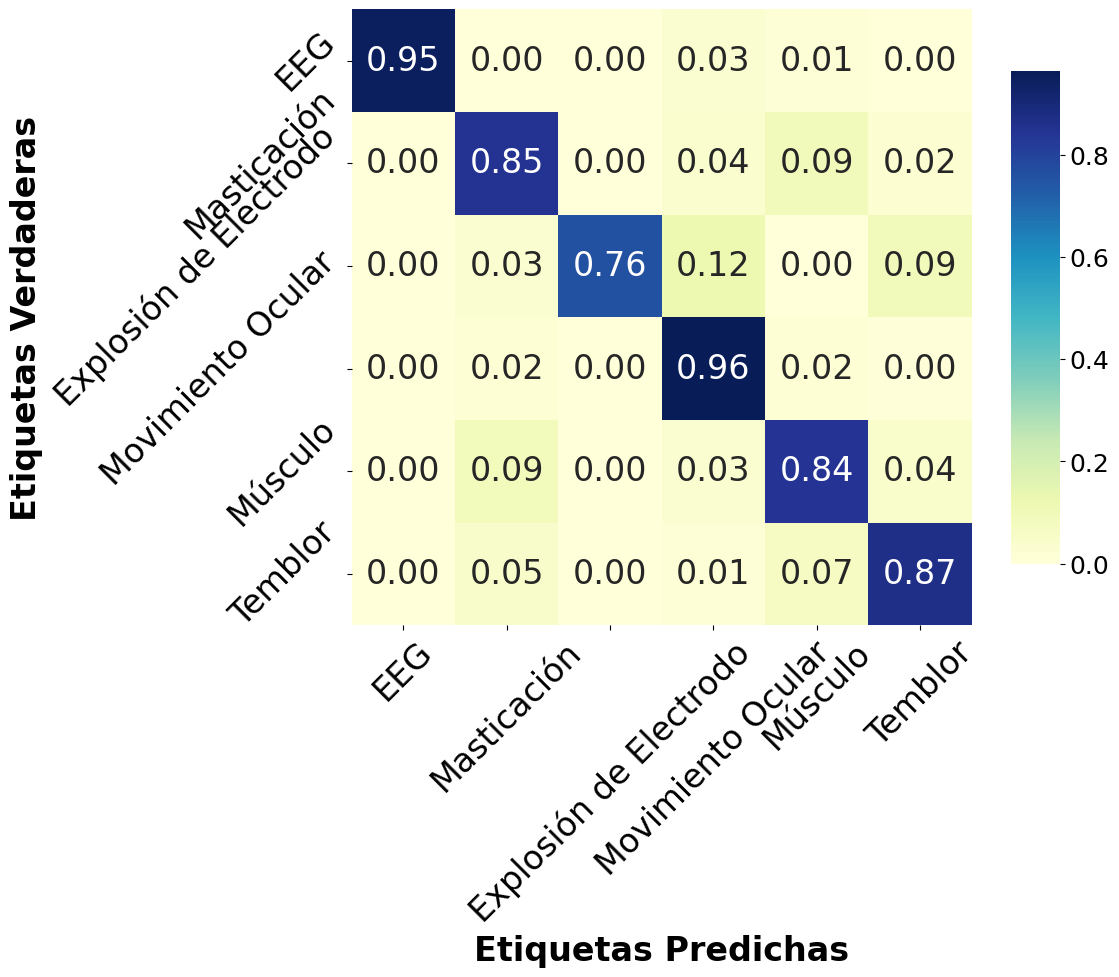

Evaluando dominio source: 100%|██████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.66it/s]



Evaluación para el dominio source (Fuente):
  Exactitud General (micro): 0.8976
  Exactitud Promedio por Clase (macro): 0.9659
  Precisión General (macro): 0.9120
  Sensibilidad General (macro): 0.8719
  F1 General (macro): 0.8889

Métricas por clase:
Clase EEG:
  - Exactitud   : 0.9887
  - Precisión   : 0.9965
  - Sensibilidad: 0.9521
  - F1          : 0.9738
  - Especificidad: 0.9991
  - Soporte     : 898
Clase Chewing:
  - Exactitud   : 0.9390
  - Precisión   : 0.8671
  - Sensibilidad: 0.8452
  - F1          : 0.8560
  - Especificidad: 0.9646
  - Soporte     : 872
Clase Electrode pop:
  - Exactitud   : 0.9980
  - Precisión   : 1.0000
  - Sensibilidad: 0.7576
  - F1          : 0.8621
  - Especificidad: 1.0000
  - Soporte     : 33
Clase Eye movement:
  - Exactitud   : 0.9678
  - Precisión   : 0.9011
  - Sensibilidad: 0.9644
  - F1          : 0.9317
  - Especificidad: 0.9688
  - Soporte     : 926
Clase Muscle:
  - Exactitud   : 0.9323
  - Precisión   : 0.8382
  - Sensibilidad: 0.8430


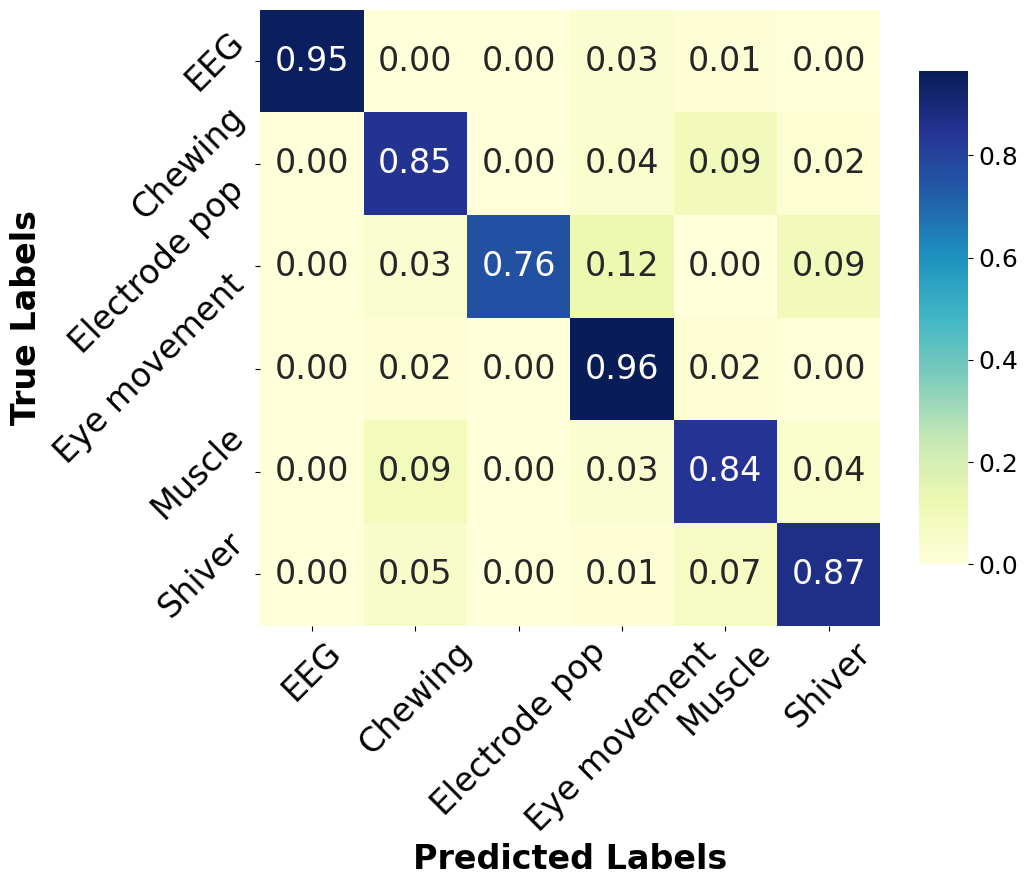

(0.897612601525966,
 np.float64(0.965870867175322),
 0.9120034851992864,
 0.8719099126256745,
 0.8888827605846492,
 [np.float64(0.9886783165148905),
  np.float64(0.9389613586020182),
  np.float64(0.998031011567807),
  np.float64(0.9677578144228403),
  np.float64(0.932316022643367),
  np.float64(0.9694806793010091)],
 array([0.9965035 , 0.86705882, 1.        , 0.90110999, 0.83815029,
        0.86919831]),
 array([0.95211581, 0.84518349, 0.75757576, 0.96436285, 0.84302326,
        0.86919831]),
 array([0.9738041 , 0.85598142, 0.86206897, 0.93166406, 0.84057971,
        0.86919831]),
 [np.float64(0.9990521327014218),
  np.float64(0.9645879034785334),
  np.float64(1.0),
  np.float64(0.9687599617468919),
  np.float64(0.9562909772088667),
  np.float64(0.9827249930342714)],
 array([[0.95211581, 0.        , 0.        , 0.03229399, 0.01447661,
         0.00111359],
        [0.00229358, 0.84518349, 0.        , 0.03669725, 0.09174312,
         0.02408257],
        [0.        , 0.03030303, 0.75757

In [38]:
evaluate_domain(model_source, test_loader, class_names, device, domain='source', language='es')
evaluate_domain(model_source, test_loader, class_names, device, domain='source', language='en')
#evaluate_domain(model_source, train_loader, class_names, device, domain='source', language='es')
#evaluate_domain(model_source, train_loader, class_names, device, domain='source', language='en')

Evaluando dominio target: 100%|██████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.38it/s]



Evaluación para el dominio target (Objetivo):
  Exactitud General (micro): 0.6921
  Exactitud Promedio por Clase (macro): 0.8974
  Precisión General (macro): 0.6970
  Sensibilidad General (macro): 0.6470
  F1 General (macro): 0.6549

Métricas por clase:
Clase EEG:
  - Exactitud   : 0.8846
  - Precisión   : 0.6571
  - Sensibilidad: 0.9989
  - F1          : 0.7928
  - Especificidad: 0.8521
  - Soporte     : 898
Clase Masticación:
  - Exactitud   : 0.8696
  - Precisión   : 0.6724
  - Sensibilidad: 0.7649
  - F1          : 0.7157
  - Especificidad: 0.8982
  - Soporte     : 872
Clase Explosión de Electrodo:
  - Exactitud   : 0.9941
  - Precisión   : 0.6957
  - Sensibilidad: 0.4848
  - F1          : 0.5714
  - Especificidad: 0.9983
  - Soporte     : 33
Clase Movimiento Ocular:
  - Exactitud   : 0.8693
  - Precisión   : 0.7747
  - Sensibilidad: 0.6015
  - F1          : 0.6772
  - Especificidad: 0.9484
  - Soporte     : 926
Clase Músculo:
  - Exactitud   : 0.8597
  - Precisión   : 0.7695
  - 

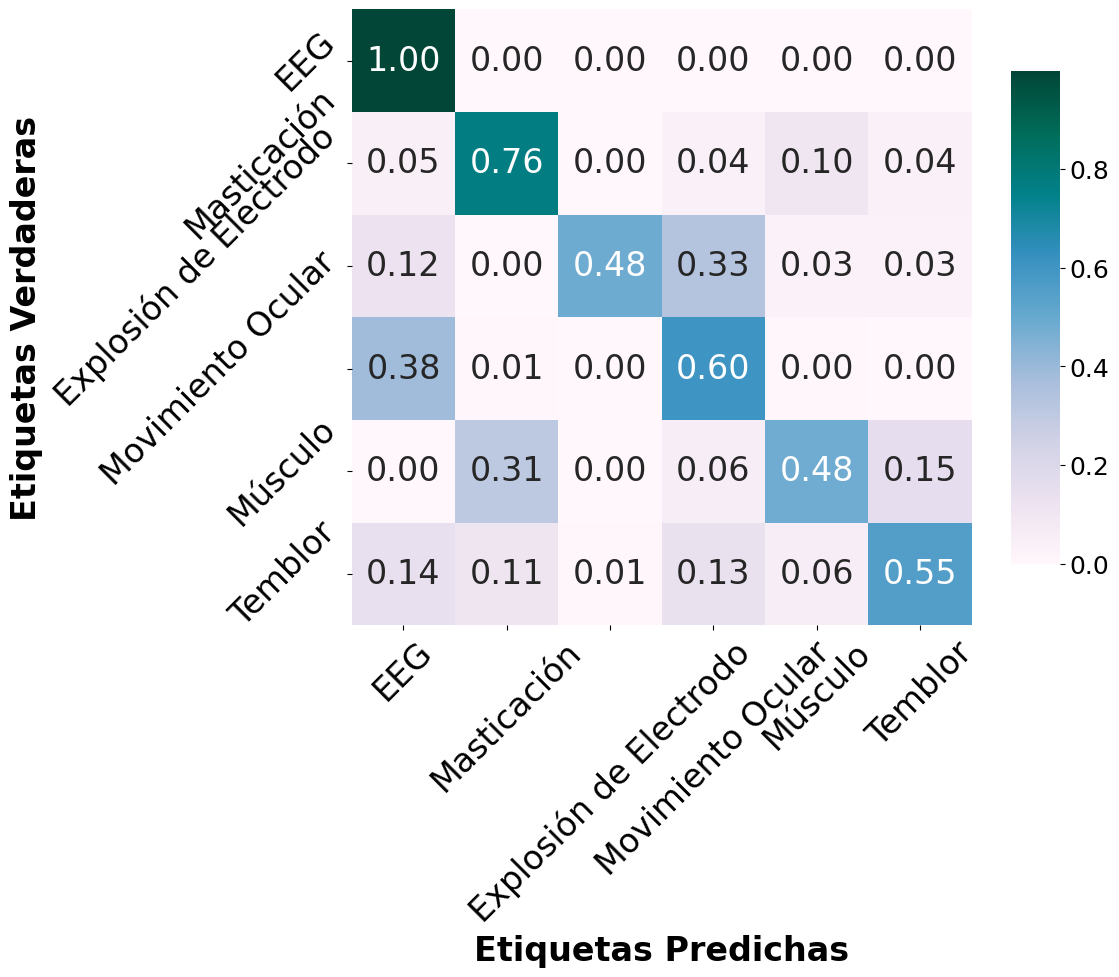

Evaluando dominio target: 100%|██████████████████████████████████████████████████████| 127/127 [00:07<00:00, 16.18it/s]



Evaluación para el dominio target (Objetivo):
  Exactitud General (micro): 0.6921
  Exactitud Promedio por Clase (macro): 0.8974
  Precisión General (macro): 0.6970
  Sensibilidad General (macro): 0.6470
  F1 General (macro): 0.6549

Métricas por clase:
Clase EEG:
  - Exactitud   : 0.8846
  - Precisión   : 0.6571
  - Sensibilidad: 0.9989
  - F1          : 0.7928
  - Especificidad: 0.8521
  - Soporte     : 898
Clase Chewing:
  - Exactitud   : 0.8696
  - Precisión   : 0.6724
  - Sensibilidad: 0.7649
  - F1          : 0.7157
  - Especificidad: 0.8982
  - Soporte     : 872
Clase Electrode pop:
  - Exactitud   : 0.9941
  - Precisión   : 0.6957
  - Sensibilidad: 0.4848
  - F1          : 0.5714
  - Especificidad: 0.9983
  - Soporte     : 33
Clase Eye movement:
  - Exactitud   : 0.8693
  - Precisión   : 0.7747
  - Sensibilidad: 0.6015
  - F1          : 0.6772
  - Especificidad: 0.9484
  - Soporte     : 926
Clase Muscle:
  - Exactitud   : 0.8597
  - Precisión   : 0.7695
  - Sensibilidad: 0.481

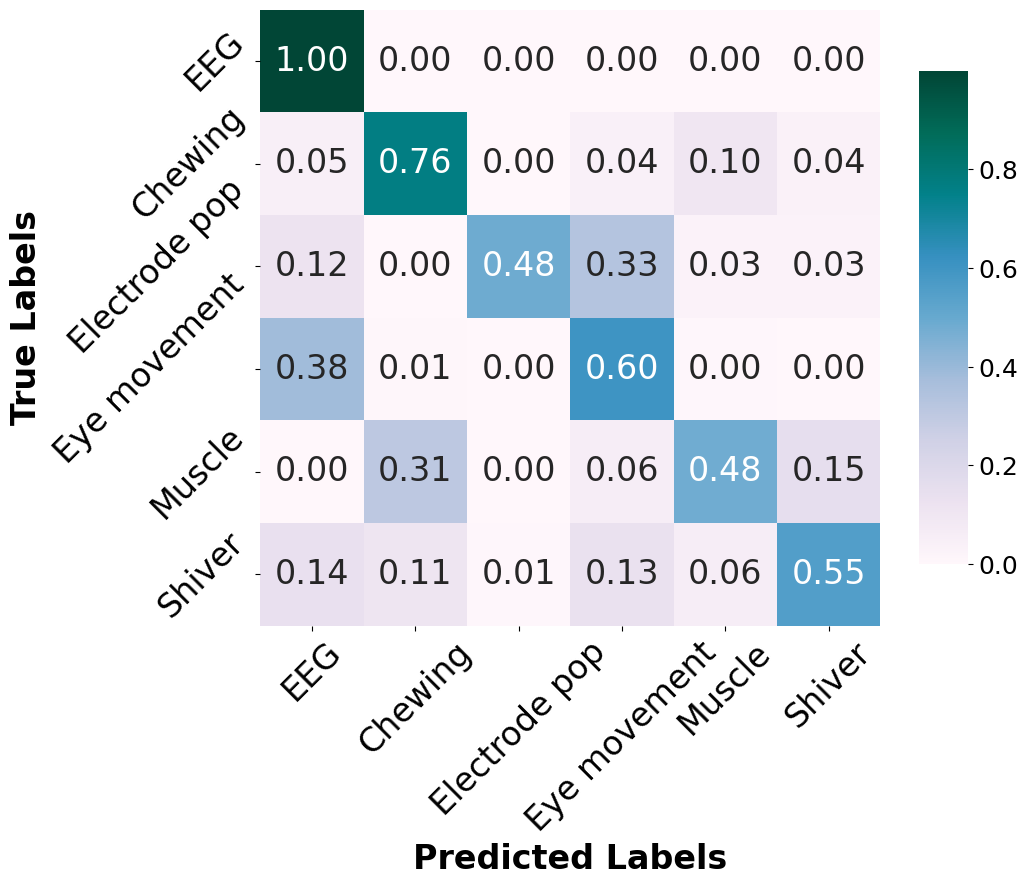

(0.6920994339158257,
 np.float64(0.897366477971942),
 0.697008985607516,
 0.6470305492104012,
 0.654887519295719,
 [np.float64(0.8845680531626877),
  np.float64(0.8695545163672164),
  np.float64(0.9940930347034211),
  np.float64(0.8693083928131923),
  np.float64(0.8597095742062515),
  np.float64(0.9069652965788826)],
 array([0.65714286, 0.67237903, 0.69565217, 0.77468707, 0.76951673,
        0.61267606]),
 array([0.99888641, 0.76490826, 0.48484848, 0.60151188, 0.48139535,
        0.55063291]),
 array([0.79275298, 0.71566524, 0.57142857, 0.67720365, 0.59227468,
        0.58      ]),
 [np.float64(0.852132701421801),
  np.float64(0.8981510498276403),
  np.float64(0.9982630272952854),
  np.float64(0.9483583041122091),
  np.float64(0.9612862940992819),
  np.float64(0.9540261911395932)],
 array([[0.99888641, 0.        , 0.        , 0.00111359, 0.        ,
         0.        ],
        [0.04931193, 0.76490826, 0.00344037, 0.0412844 , 0.10321101,
         0.03784404],
        [0.12121212, 0.  

In [39]:
evaluate_domain(model_target, test_loader, class_names, device, domain='target', language='es')
evaluate_domain(model_target, test_loader, class_names, device, domain='target', language='en')
#evaluate_domain(model_target, train_loader, class_names, device, domain='target', language='es')
#evaluate_domain(model_target, train_loader, class_names, device, domain='target', language='en')

Evaluando dominio source: 100%|██████████████████████████████████████████████████████| 127/127 [00:07<00:00, 16.37it/s]



Evaluación para el dominio source (Fuente):
  Exactitud General (micro): 0.8976
  Exactitud Promedio por Clase (macro): 0.9659
  Precisión General (macro): 0.9120
  Sensibilidad General (macro): 0.8719
  F1 General (macro): 0.8889

Métricas por clase:
Clase EEG:
  - Exactitud   : 0.9887
  - Precisión   : 0.9965
  - Sensibilidad: 0.9521
  - F1          : 0.9738
  - Especificidad: 0.9991
  - Soporte     : 898
Clase Chewing:
  - Exactitud   : 0.9390
  - Precisión   : 0.8671
  - Sensibilidad: 0.8452
  - F1          : 0.8560
  - Especificidad: 0.9646
  - Soporte     : 872
Clase Electrode pop:
  - Exactitud   : 0.9980
  - Precisión   : 1.0000
  - Sensibilidad: 0.7576
  - F1          : 0.8621
  - Especificidad: 1.0000
  - Soporte     : 33
Clase Eye movement:
  - Exactitud   : 0.9678
  - Precisión   : 0.9011
  - Sensibilidad: 0.9644
  - F1          : 0.9317
  - Especificidad: 0.9688
  - Soporte     : 926
Clase Muscle:
  - Exactitud   : 0.9323
  - Precisión   : 0.8382
  - Sensibilidad: 0.8430


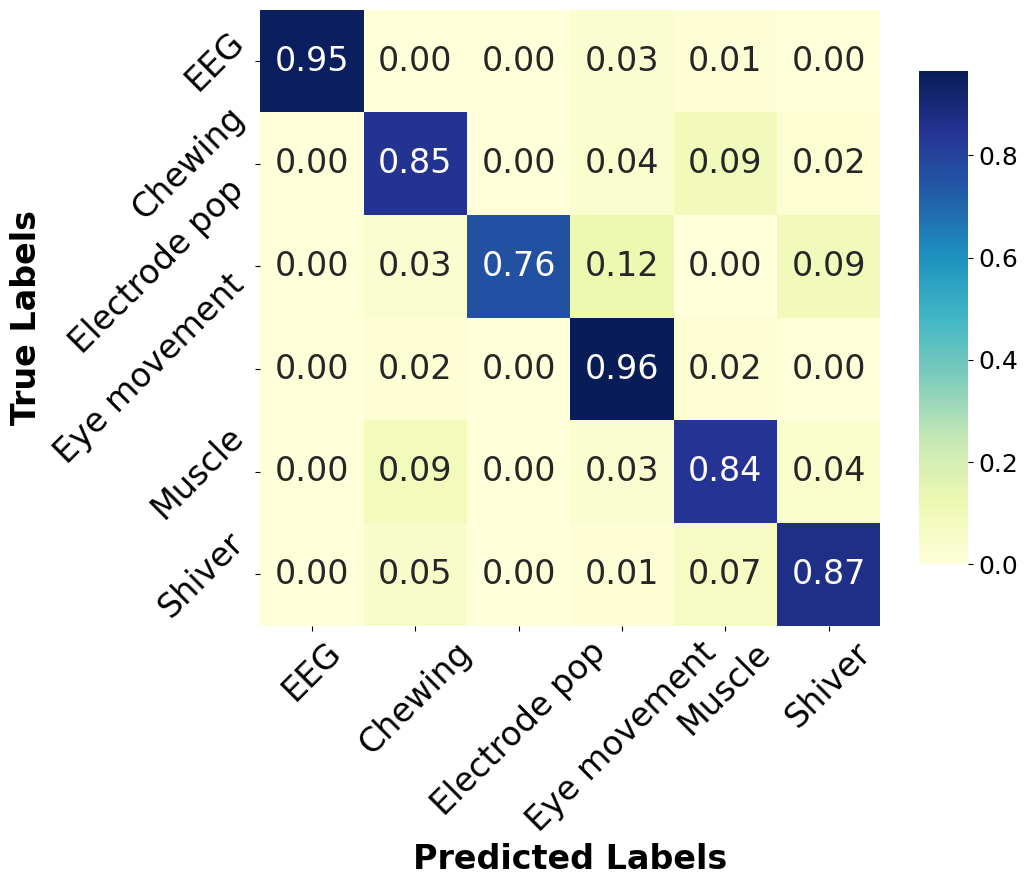

Evaluando dominio target: 100%|██████████████████████████████████████████████████████| 127/127 [00:09<00:00, 13.18it/s]



Evaluación para el dominio target (Objetivo):
  Exactitud General (micro): 0.6921
  Exactitud Promedio por Clase (macro): 0.8974
  Precisión General (macro): 0.6970
  Sensibilidad General (macro): 0.6470
  F1 General (macro): 0.6549

Métricas por clase:
Clase EEG:
  - Exactitud   : 0.8846
  - Precisión   : 0.6571
  - Sensibilidad: 0.9989
  - F1          : 0.7928
  - Especificidad: 0.8521
  - Soporte     : 898
Clase Chewing:
  - Exactitud   : 0.8696
  - Precisión   : 0.6724
  - Sensibilidad: 0.7649
  - F1          : 0.7157
  - Especificidad: 0.8982
  - Soporte     : 872
Clase Electrode pop:
  - Exactitud   : 0.9941
  - Precisión   : 0.6957
  - Sensibilidad: 0.4848
  - F1          : 0.5714
  - Especificidad: 0.9983
  - Soporte     : 33
Clase Eye movement:
  - Exactitud   : 0.8693
  - Precisión   : 0.7747
  - Sensibilidad: 0.6015
  - F1          : 0.6772
  - Especificidad: 0.9484
  - Soporte     : 926
Clase Muscle:
  - Exactitud   : 0.8597
  - Precisión   : 0.7695
  - Sensibilidad: 0.481

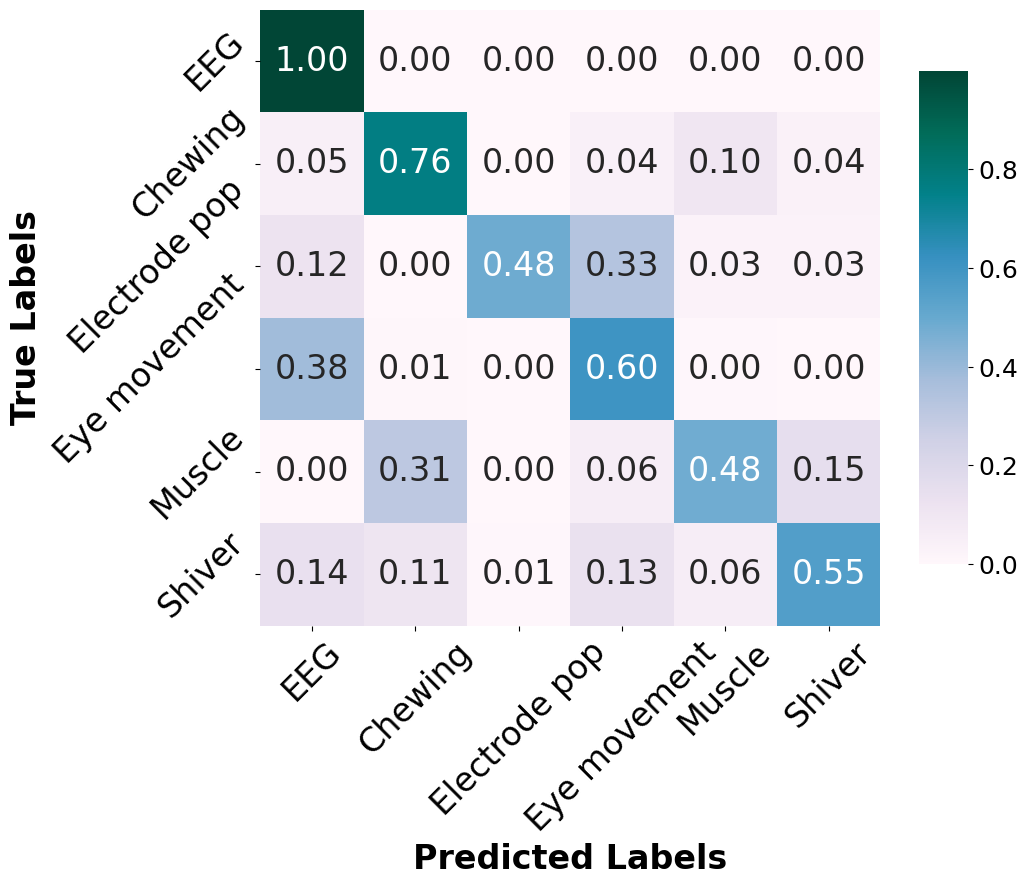


=== Resumen general ===
Source: Acc(micro)=0.8976 | Acc(macro)=0.9659 | P=0.9120 | R=0.8719 | F1=0.8889
Target: Acc(micro)=0.6921 | Acc(macro)=0.8974 | P=0.6970 | R=0.6470 | F1=0.6549
AVG : Acc(micro)=0.7949 | Acc(macro)=0.9316 | P=0.8045 | R=0.7595 | F1=0.7719


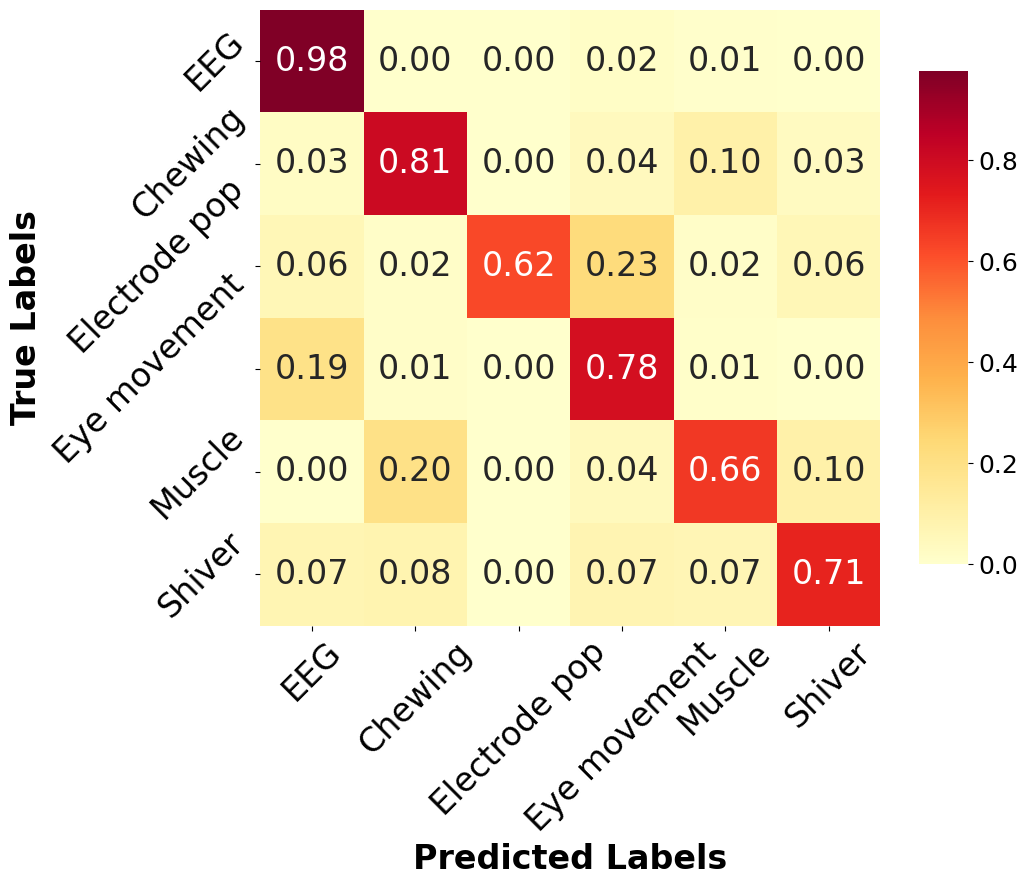

In [40]:
import numpy as np

def evaluate_both_domains_with_confusion(
    model_source, model_target, dataloader, class_names, device, language='es'
):
    (src_acc, src_macro_acc, src_prec, src_rec, src_f1,
     src_cls_acc, src_cls_prec, src_cls_rec, src_cls_f1,
     src_cls_spec, src_cm) = evaluate_domain(
        model_source, dataloader, class_names, device,
        domain='source', language=language
    )

    (tgt_acc, tgt_macro_acc, tgt_prec, tgt_rec, tgt_f1,
     tgt_cls_acc, tgt_cls_prec, tgt_cls_rec, tgt_cls_f1,
     tgt_cls_spec, tgt_cm) = evaluate_domain(
        model_target, dataloader, class_names, device,
        domain='target', language=language
    )

    avg_metrics = {
        'accuracy_micro': (src_acc + tgt_acc) / 2.0,
        'accuracy_macro': (src_macro_acc + tgt_macro_acc) / 2.0,
        'precision_macro': (src_prec + tgt_prec) / 2.0,
        'recall_macro': (src_rec + tgt_rec) / 2.0,
        'f1_macro': (src_f1 + tgt_f1) / 2.0
    }

    avg_conf_matrix = (src_cm + tgt_cm) / 2.0

    # Promedios por clase
    avg_per_class = {
        'accuracy': (np.array(src_cls_acc) + np.array(tgt_cls_acc)) / 2.0,
        'precision': (np.array(src_cls_prec) + np.array(tgt_cls_prec)) / 2.0,
        'recall': (np.array(src_cls_rec) + np.array(tgt_cls_rec)) / 2.0,
        'f1': (np.array(src_cls_f1) + np.array(tgt_cls_f1)) / 2.0,
        'specificity': (np.array(src_cls_spec) + np.array(tgt_cls_spec)) / 2.0
    }

    dom_lbl = {'es': ('Fuente', 'Objetivo'), 'en': ('Source', 'Target')}
    s_lbl, t_lbl = dom_lbl.get(language, ('Source', 'Target'))
    print("\n=== Resumen general ===")
    print(f"{s_lbl}: Acc(micro)={src_acc:.4f} | Acc(macro)={src_macro_acc:.4f} | "
          f"P={src_prec:.4f} | R={src_rec:.4f} | F1={src_f1:.4f}")
    print(f"{t_lbl}: Acc(micro)={tgt_acc:.4f} | Acc(macro)={tgt_macro_acc:.4f} | "
          f"P={tgt_prec:.4f} | R={tgt_rec:.4f} | F1={tgt_f1:.4f}")
    print(f"AVG : Acc(micro)={avg_metrics['accuracy_micro']:.4f} | "
          f"Acc(macro)={avg_metrics['accuracy_macro']:.4f} | "
          f"P={avg_metrics['precision_macro']:.4f} | "
          f"R={avg_metrics['recall_macro']:.4f} | "
          f"F1={avg_metrics['f1_macro']:.4f}")

    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10,8))
    ax = sns.heatmap(
        avg_conf_matrix,
        annot=True, fmt=".2f", cmap="YlOrRd",
        xticklabels=class_names,
        yticklabels=class_names,
        annot_kws={"size":24},
        cbar_kws={"shrink":0.8,"aspect":10}
    )
    ax.collections[0].colorbar.ax.tick_params(labelsize=18)

    title = (
        "Matriz de Confusión Promedio (Fuente + Objetivo)"
        if language=='es' else
        "Confusion Matrix (Source - Target)"
    )
    xlabel = "Etiquetas Predichas" if language=='es' else "Predicted Labels"
    ylabel = "Etiquetas Verdaderas" if language=='es' else "True Labels"

    plt.xlabel(xlabel, fontsize=24, fontweight='bold')
    plt.ylabel(ylabel, fontsize=24, fontweight='bold')
    #plt.title(title, fontsize=26, fontweight='bold')
    plt.xticks(rotation=45, fontsize=24)
    plt.yticks(rotation=45, fontsize=24)
    plt.show()

    return {
        'source_metrics': (src_acc, src_macro_acc, src_prec, src_rec, src_f1),
        'target_metrics': (tgt_acc, tgt_macro_acc, tgt_prec, tgt_rec, tgt_f1),
        'avg_metrics': avg_metrics,
        'avg_conf_matrix': avg_conf_matrix,
        'per_class_avg': avg_per_class
    }


resultados = evaluate_both_domains_with_confusion(
    model_source,
    model_target,
    test_loader,
    class_names,
    device,
    language='en'
)

In [41]:
import pandas as pd
sns.set_style("darkgrid")

def plot_training_metrics(csv_path, language='en', save_path=None, y_min=0.0, y_max=1.0):
    plt.rc('font', family='Times New Roman')
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(10, 6))
    
    if language == 'es':
        plt.plot(df.index, df['Train Source Acc'], label='Exactitud de Entrenamiento (Fuente)', 
                 linewidth=1, linestyle='-', marker='x', markersize=5)
        plt.plot(df.index, df['Train Target Acc'], label='Exactitud de Entrenamiento (Objetivo)', 
                 linewidth=1, linestyle='--', marker='s', markersize=5)
        plt.plot(df.index, df['Val Source Acc'], label='Exactitud de Validación (Fuente)', 
                 linewidth=1, linestyle='-.', marker='^', markersize=5)
        plt.plot(df.index, df['Val Target Acc'], label='Exactitud de Validación (Objetivo)', 
                 linewidth=1, linestyle=':', marker='d', markersize=5)
        
        plt.title('Entrenamiento y Validación de Exactitud\n', fontsize=24, fontweight='bold')
        plt.xlabel('Épocas', fontsize=24, fontweight='bold')
        plt.ylabel('Exactitud', fontsize=24, fontweight='bold')
    else:
        plt.plot(df.index, df['Train Source Acc'], label='Training Accuracy (Source)', 
                 linewidth=1, linestyle='-', marker='x', markersize=5)
        plt.plot(df.index, df['Train Target Acc'], label='Training Accuracy (Target)', 
                 linewidth=1, linestyle='--', marker='s', markersize=5)
        plt.plot(df.index, df['Val Source Acc'], label='Validation Accuracy (Source)', 
                 linewidth=1, linestyle='-.', marker='^', markersize=5)
        plt.plot(df.index, df['Val Target Acc'], label='Validation Accuracy (Target)', 
                 linewidth=1, linestyle=':', marker='d', markersize=5)
        
        #plt.title('Training and Validation Accuracy\n', fontsize=24, fontweight='bold')
        plt.xlabel('Epochs', fontsize=24, fontweight='bold')
        plt.ylabel('Accuracy', fontsize=24, fontweight='bold')
    
    plt.ylim(0.5, 1)
    plt.xticks(ticks=range(0, len(df.index) + 10, 10), fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(
        loc='lower right',
        fontsize=20,
        labelspacing=0.5,   # Espaciado vertical entre líneas
        borderpad=0.5,      # Espacio interno entre la caja y el texto
        frameon=True,
        fancybox=True
    )
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


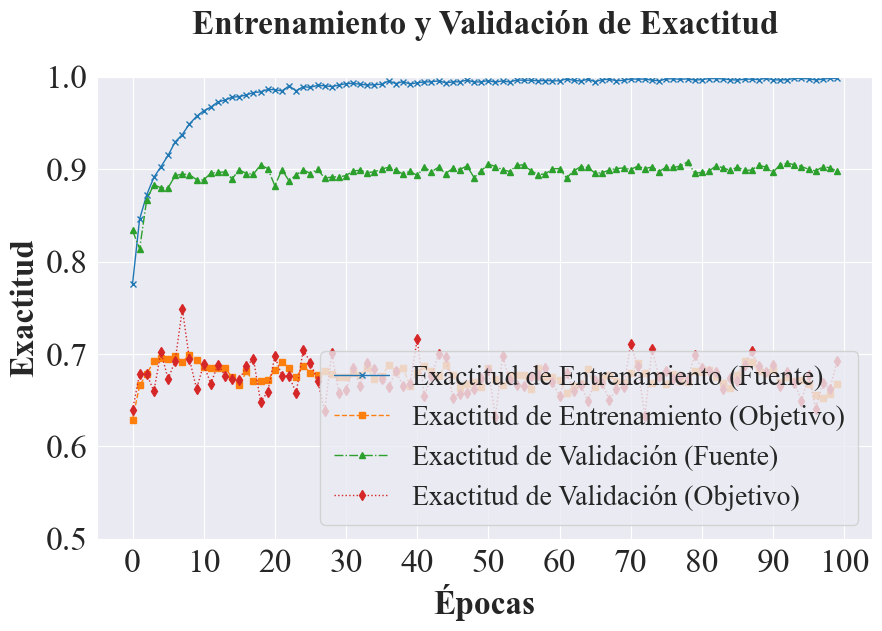

In [42]:
plot_training_metrics('training_metrics_stft.csv', language='es')

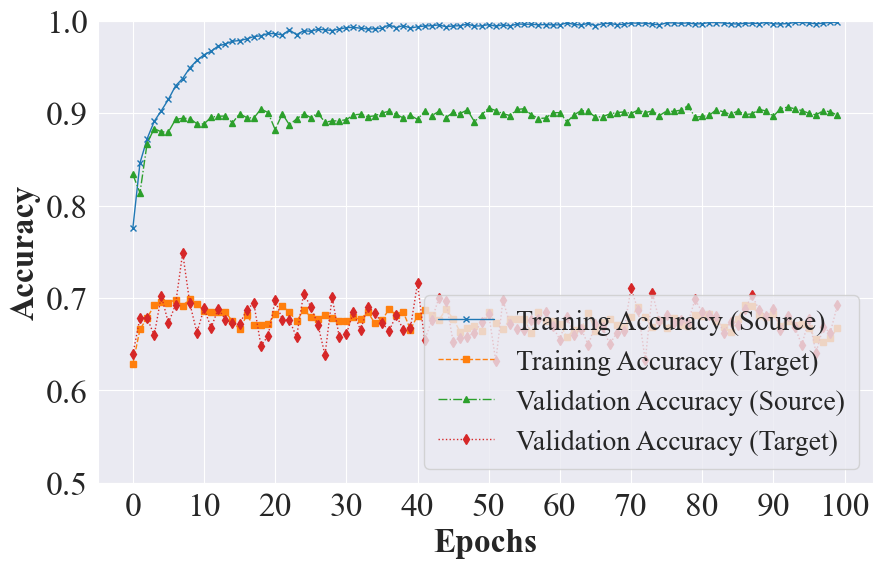

In [43]:
plot_training_metrics('training_metrics_stft.csv', language='en')

In [44]:
def plot_domain_adaptation_loss(csv_path, language='en', save_path=None):
    plt.rc('font', family='Times New Roman')
    df = pd.read_csv(csv_path)
    
    plt.figure(figsize=(10, 6))
    
    if language == 'es':
        plt.plot(df.index, df['Train Loss'], label='Pérdida de Adaptación de Dominio', 
                 linewidth=1.8, color='blue', linestyle='dotted', marker='1', markersize=10)
        plt.title('Pérdida de Adaptación de Dominio\n', fontsize=18, fontweight='bold')
        plt.xlabel('Épocas', fontsize=18, fontweight='bold')
        plt.ylabel('Pérdida', fontsize=18, fontweight='bold')
    else:
        plt.plot(df.index, df['Train Loss'], label='Domain Adaptation Loss', 
                 linewidth=1.8, color='blue', linestyle='dotted', marker='1', markersize=10)
        #plt.title('Domain Adaptation Loss\n', fontsize=18, fontweight='bold')
        plt.xlabel('Epochs', fontsize=18, fontweight='bold')
        plt.ylabel('Loss', fontsize=18, fontweight='bold')
    
    plt.xticks(ticks=range(0, len(df.index) + 1, 5), fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='upper right', fontsize=18)
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

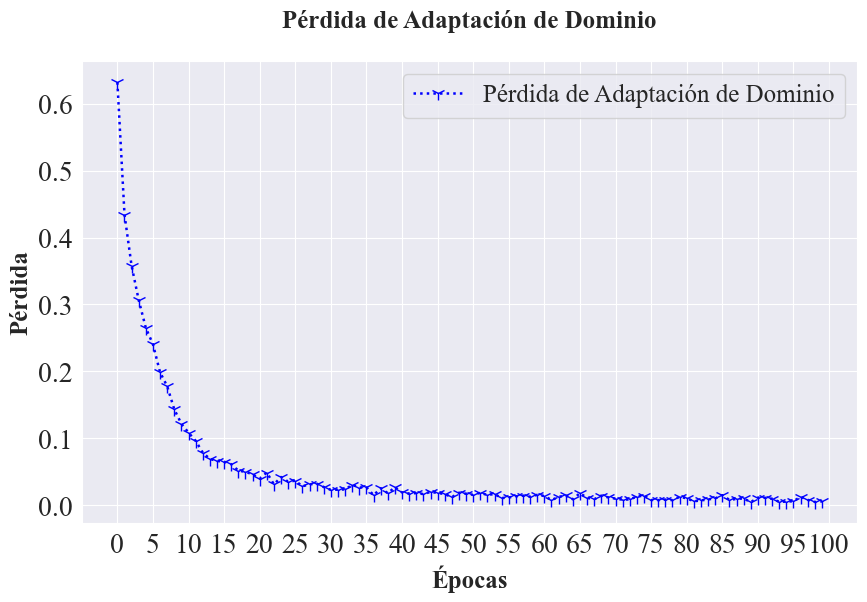

In [45]:
plot_domain_adaptation_loss('training_metrics_stft.csv', language='es')

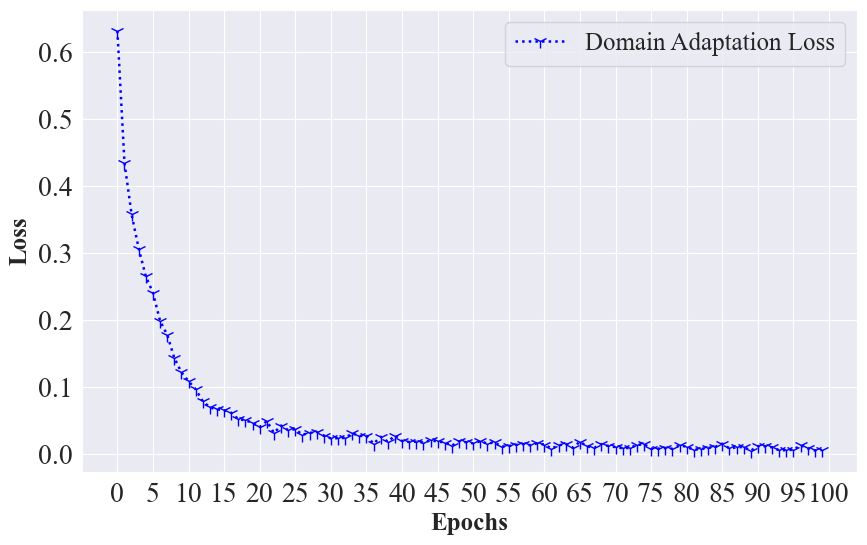

In [46]:
plot_domain_adaptation_loss('training_metrics_stft.csv', language='en')

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_divergence_metrics(csv_path, language='en', save_path=None):
    plt.rc('font', family='Times New Roman')
    df = pd.read_csv(csv_path)
    
    plt.figure(figsize=(10, 6))

    if language == 'es':
        plt.plot(df.index, df['Avg KL Divergence'], label='Divergencia KL Promedio', 
                 linewidth=1.8, color='blue', linestyle='dotted', marker='1', markersize=10)
        plt.plot(df.index, df['Avg Jensen-Shannon Divergence'], label='Divergencia Jensen-Shannon Promedio', 
                 linewidth=1.8, color='green', linestyle='dotted', marker='2', markersize=10)
        plt.plot(df.index, df['Avg Jensen-Shannon Distance'], label='Distancia Jensen-Shannon Promedio', 
                 linewidth=1.8, color='red', linestyle='dotted', marker='3', markersize=10)
        
        plt.title('Métricas de Divergencia y Distancia\n', fontsize=24, fontweight='bold')
        plt.xlabel('Epocas', fontsize=24, fontweight='bold')
        plt.ylabel('Valores', fontsize=24, fontweight='bold')
    else:
        plt.plot(df.index, df['Avg KL Divergence'], label='Avg KL Divergence', 
                 linewidth=1.8, color='blue', linestyle='dotted', marker='1', markersize=10)
        plt.plot(df.index, df['Avg Jensen-Shannon Divergence'], label='Avg Jensen-Shannon Divergence', 
                 linewidth=1.8, color='green', linestyle='dotted', marker='2', markersize=10)
        plt.plot(df.index, df['Avg Jensen-Shannon Distance'], label='Avg Jensen-Shannon Distance', 
                 linewidth=1.8, color='red', linestyle='dotted', marker='3', markersize=10)
        
        #plt.title('Domain Adaptation Distance and Divergence Metrics\n', fontsize=24, fontweight='bold')
        plt.xlabel('Epochs', fontsize=24, fontweight='bold')
        plt.ylabel('Values', fontsize=24, fontweight='bold')
    
    plt.xticks(ticks=range(0, len(df.index) + 10, 10), fontsize=24)
    
    y_min = int(df[['Avg KL Divergence', 'Avg Jensen-Shannon Divergence', 'Avg Jensen-Shannon Distance']].min().min())
    y_max = int(df[['Avg KL Divergence', 'Avg Jensen-Shannon Divergence', 'Avg Jensen-Shannon Distance']].max().max())
    plt.yticks(ticks=range(y_min, y_max + 1, 1), fontsize=24)
    
    plt.legend(loc='upper right', fontsize=24)
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()


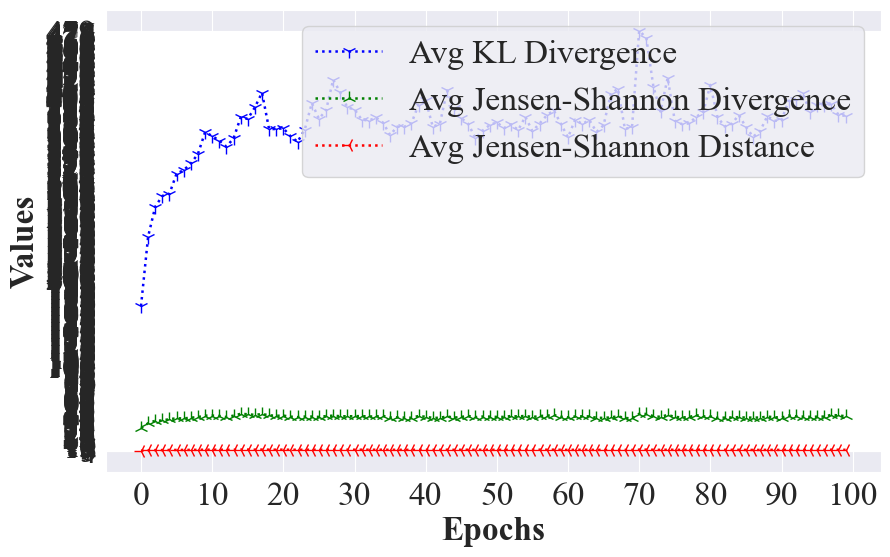

In [48]:
plot_divergence_metrics('divergence_metrics_stft.csv', language='en')

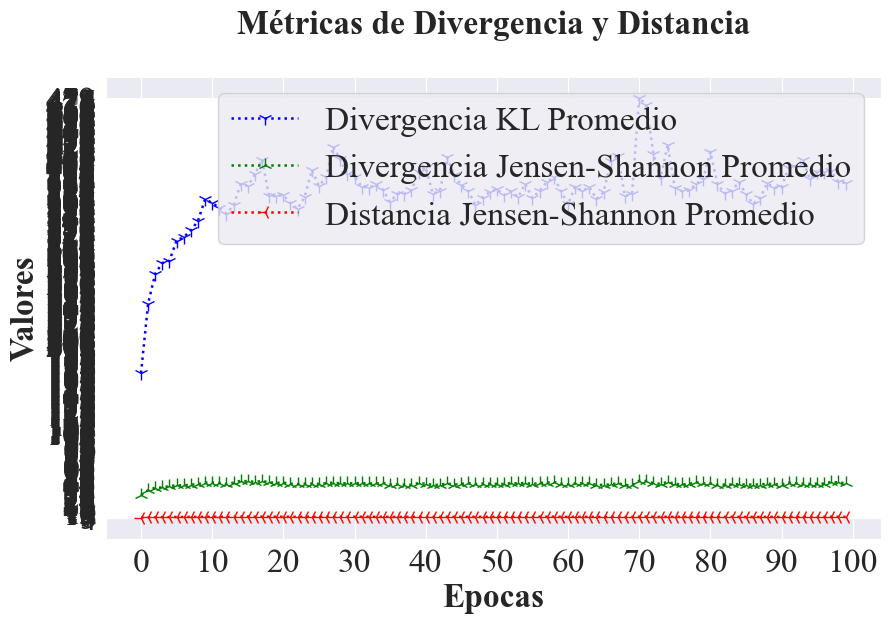

In [49]:
plot_divergence_metrics('divergence_metrics_stft.csv', language='es')